> ERC Starting Grant on COeXISTENCE between humans and machines in urban mobility.


<img src="../images/img_mileston1.png" alt="Milestone 1 Image" width="500" height="400">

# Title: Machine training using DQN algorithm
## Name: Anastasia
### Date: July 11, 2024
---

### Description

> In this notebook, we implement the training of independent machine agents using the DQN algorithm.
---

## Objective

> The purpose of this notebook is to understand whether DQN algorithm can train effectively our RL agents.
---

## Experiment Summary

### Network Architecture
- Csomor network


### Agents
| **Type**          |           |
|-------------------|---------------------|
| **Number**        | 3 machines |
| **Total demand** | random |


### Origin and Destination Details
| **Origin Count**      | 2                            |
|-----------------------|------------------------------|
| **Destination Count** | 2                            |
| **Origin Pairing**    | 279952229#0, 115604053       |
| **Destination Pairing**| -115602933#2, -441496282#1     |

    

### Hardware Utilized for Experiment Execution
| **Type of Machine** | Personal computer (or server) |
|----------------------|-------------------------------|
| **CPU**              | 12th Gen Intel(R) Core(TM) i7-1255U |
|                      | Cores: 10                   |
|                      | Sockets: 1                  |
|                      | Base Speed: 1.70 GHz        |
| **Memory**           | 16GB                          |
| **Disc (SSD)**       | 477 GB                        |
| **Operating System** | Windows 11                    |


### Imported libraries 

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensordict.nn import TensorDictModule, TensorDictSequential
import torch
from torchrl.collectors import SyncDataCollector
from torch.distributions import Categorical
from torchrl.envs.libs.pettingzoo import PettingZooWrapper
from torchrl.envs.transforms import TransformedEnv, RewardSum
from torchrl.envs.utils import check_env_specs
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.modules import MultiAgentMLP, ProbabilisticActor
from torchrl.objectives.value import GAE
from torchrl.objectives import ClipPPOLoss, ValueEstimators
from torchrl.modules import MLP, QValueActor
from torchrl.data import CompositeSpec
from torchrl.modules import EGreedyModule
from torchrl.objectives import DQNLoss, HardUpdate
from tqdm import tqdm
import sys


from environment import TrafficEnvironment
from keychain import Keychain as kc
from services.plotter import Plotter
from utilities import get_params

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Hyperparameters specification

In [2]:
# Devices
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
vmas_device = device  # The device where the simulator is run

# Sampling
frames_per_batch = 18  # Number of team frames collected per training iteration
n_iters = 100  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 100  # Number of optimization steps per training iteration
minibatch_size = 2  # Size of the mini-batches in each optimization step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients

# DQN
gamma = 0.99  # discount factor
hard_update_freq = 10

### Environment Creation

In [3]:
params = get_params(kc.PARAMS_PATH)

In [4]:
env = TrafficEnvironment(params[kc.RUNNER], params[kc.ENVIRONMENT], params[kc.SIMULATOR], params[kc.AGENT_GEN], params[kc.AGENTS], params[kc.PHASE])

[CONFIRMED] Environment variable exists: SUMO_HOME
[SUCCESS] Added module directory: C:\Program Files (x86)\Eclipse\Sumo\tools


c:\Users\Anastasia\anaconda3\envs\torchrl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
env.start()

In [6]:
env = PettingZooWrapper(
    env=env,
    use_mask=True,
    group_map=None,
    categorical_actions=True,
    done_on_any = False
)

In [7]:
out_keys = []

for group, agents in env.group_map.items():
    out_keys.append((group, "episode_reward"))

print(out_keys)

[('18', 'episode_reward'), ('10', 'episode_reward'), ('23', 'episode_reward'), ('12', 'episode_reward'), ('4', 'episode_reward'), ('7', 'episode_reward')]


In [8]:
env = TransformedEnv(
    env,
    RewardSum(
        in_keys=env.reward_keys,
        reset_keys=["_reset"] * len(env.group_map.keys()),
        out_keys = out_keys
    ),
)

In [9]:
env.reward_keys

[('10', 'reward'),
 ('12', 'reward'),
 ('18', 'reward'),
 ('23', 'reward'),
 ('4', 'reward'),
 ('7', 'reward')]

In [10]:
env.group_map.keys()

dict_keys(['18', '10', '23', '12', '4', '7'])

In [11]:
check_env_specs(env)

2024-07-11 17:36:39,375 [torchrl][INFO] check_env_specs succeeded!


In [12]:
reset_td = env.reset()

### Policy network

In [13]:
q_value_module = {}
for group, agents in env.group_map.items():
    share_parameters_policy = False  # Can change this based on the group

    mlp = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs= env.full_action_spec[group, "action"].space.n,  # n_actions_per_agents
        n_agents=len(agents),  # Number of agents in the group
        centralised=False,  # the policies are decentralised (i.e., each agent will act from its local observation)
        share_params=share_parameters_policy,
        device=device,
        depth=4,
        num_cells=64,
        activation_class=torch.nn.ReLU,
    )

    # Wrap the neural network in a :class:`~tensordict.nn.TensorDictModule`.
    # This is simply a module that will read the ``in_keys`` from a tensordict, feed them to the
    # neural networks, and write the
    # outputs in-place at the ``out_keys``.

    q_value_actor = QValueActor(
        mlp,
        spec=CompositeSpec(action=env.action_spec[group]),
        in_keys=[(group, "observation")],
    )  

    print("group is: ", group)
    q_value_module[group] = q_value_actor

group is:  18
group is:  10
group is:  23
group is:  12
group is:  4
group is:  7


In [14]:
for group, agents in env.group_map.items():
    print(env.full_action_spec[group, "action"].space.n)

3
3
3
3
3
3


In [15]:
for group, agents in env.group_map.items():
    print(group, agents)

18 ['18']
10 ['10']
23 ['23']
12 ['12']
4 ['4']
7 ['7']


### Greedy module

In [16]:
greedy_mods = {}
annealing_frames = 10
eps_start=10
eps_end=5

for group, agents in env.group_map.items():

    greedy_module = EGreedyModule(
        annealing_num_steps=annealing_frames,
        eps_init=eps_start,
        eps_end=eps_end,
        spec=q_value_module[group].spec,
    )

c:\Users\Anastasia\anaconda3\envs\torchrl\Lib\site-packages\torchrl\modules\tensordict_module\exploration.py:97: UserWarning: eps_init should be a float.
  warnings.warn("eps_init should be a float.")


In [17]:
policy = TensorDictSequential(*q_value_module.values())

### Collector

In [18]:
collector = SyncDataCollector(
    env,
    policy,
    device=device,
    storing_device=device,
    frames_per_batch=frames_per_batch,
    reset_at_each_iter=True,
    total_frames=total_frames,
)

### Replay Buffer

In [19]:
replay_buffers = {}
for group, _agents in env.group_map.items():
    replay_buffers[group] = ReplayBuffer(
        storage=LazyTensorStorage(
            frames_per_batch, device=device
        ),  # We store the frames_per_batch collected at each iteration
        batch_size=minibatch_size,  # We will sample minibatches of this size
    )

### DQN loss function

In [20]:
loss_modules = {}
losses = {}
optimizers = {}

for group, _agents in env.group_map.items():
    loss_module = DQNLoss(
        value_network=q_value_module[group],
        loss_function="l2",
        delay_value=True,
    )
    loss_module.make_value_estimator(gamma=gamma)
    loss_module = loss_module.to(device)

    target_net_updater = HardUpdate(
        loss_module, value_network_update_interval=hard_update_freq
    )    

    losses[group] = loss_module

    optimizer = torch.optim.Adam(loss_module.parameters(), lr)
    
    optimizers[group] = optimizer


# Access loss module for the first group for example
group = next(iter(env.group_map))
loss_module, optimizer = loss_modules[group]

ValueError: action_space was not specified/not compatible and could not be retrieved from the value network. Got action_space=<class 'NoneType'>.

### Training loop

In [29]:
pbar = tqdm(
    total=n_iters,
    desc=", ".join(
        [f"episode_reward_mean_{group} = 0" for group in env.group_map.keys()]
    ),
)
episode_reward_mean_map = {group: [] for group in env.group_map.keys()}

loss = {group: [] for group in env.group_map.keys()}
loss_objective = {group: [] for group in env.group_map.keys()}
loss_critic = {group: [] for group in env.group_map.keys()}
loss_entropy = {group: [] for group in env.group_map.keys()}

for tensordict_data in collector:

    # Update done and terminated for both agents
    for group, _agents in env.group_map.items():
        tensordict_data.set(
            ("next", group, "done"),
            tensordict_data.get(("next", "done"))
            .unsqueeze(-1)
            .expand(tensordict_data.get_item_shape(("next", group, "reward"))),  # Adjust index to start from 0
        )
        tensordict_data.set(
            ("next", group, "terminated"),
            tensordict_data.get(("next", "terminated"))
            .unsqueeze(-1)
            .expand(tensordict_data.get_item_shape(("next", group, "reward"))),  # Adjust index to start from 0
        )
        #print("tensordict data is: ", tensordict_data.get("250", "reward"), "\n\n")

    # Compute GAE for both agents
    with torch.no_grad():
        for group, _agents in env.group_map.items():
            module = GAE(
                tensordict_data,
                params=loss_modules[group][0].critic_network_params,
                target_params=loss_modules[group][0].target_critic_network_params,
            )
            #print("module is: ", module, "\n\n")

    # Flatten and extend data for both agents
    for group, _agents in env.group_map.items():
        data_view = tensordict_data.reshape(-1)  # Flatten the batch size to shuffle data
        replay_buffers[group].extend(data_view)

    for epoch in range(num_epochs):
        for group, _agents in env.group_map.items():
            for _ in range(frames_per_batch // minibatch_size):
                subdata = replay_buffers[group].sample()
                #print("Inside inner loop", subdata, replay_buffers, "\n\n")
                loss_vals = losses[group](subdata)

                loss_value = (
                    loss_vals["loss_objective"]
                    + loss_vals["loss_critic"]
                    + loss_vals["loss_entropy"]
                )

                loss_value.backward()

                if torch.isnan(loss_value).any():
                    raise ValueError("NaNs in the loss")

                loss[group].append(loss_value)
                loss_objective[group].append(loss_vals["loss_objective"])
                loss_critic[group].append(loss_vals["loss_critic"])
                loss_entropy[group].append(loss_vals["loss_entropy"])

                torch.nn.utils.clip_grad_norm_(
                    losses[group].parameters(), max_grad_norm
                )  # Optional

                optimizers[group].step()
                optimizers[group].zero_grad()

    # Update policy weights for both agents
    #for group, _agents in env.group_map.items():
    collector.update_policy_weights_()
   

    for group, _agents in env.group_map.items():
        done = tensordict_data.get(("next", group, "done"))  # Get done status for the group

        episode_reward_mean = (
            tensordict_data.get(("next", group, "reward"))[
                tensordict_data.get(("next", group, "done"))
            ]
            .mean()
            .item()
        )

        episode_reward_mean_map[group].append(episode_reward_mean)

    pbar.set_description(
        ", ".join(
            [
                f"episode_reward_mean_{group} = {episode_reward_mean_map[group][-1]}"
                for group in env.group_map.keys()
            ]
        ),
        refresh=False,
    )
    pbar.update()

episode_reward_mean_18 = 0, episode_reward_mean_10 = 0, episode_reward_mean_23 = 0, episode_reward_mean_12 = 0, episode_reward_mean_4 = 0, episode_reward_mean_7 = 0:   0%|          | 0/100 [00:00<?, ?it/s]

Agent 0 reward: 2.3

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.783333333333333

Agent 3 reward: 1.9666666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.8

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.183333333333333

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.65

Agent 14 reward: 4.35

Agent 15 reward: 4.916666666666667

Agent 16 reward: 4.1

Agent 17 reward: 1.8166666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.15

Agent 21 reward: 4.35

Agent 22 reward: 4.833333333333333

Agent 23 reward: 5.45

Agent 0 reward: 2.316666666666667

Agent 1 reward: 4.65

Agent 2 reward: 4.3

Agent 3 reward: 2.033333333333333

Agent 4 reward: 2.5

Agent 5 reward: 1.95

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 4.966666666666667

Agent 9 rew

episode_reward_mean_18 = -1.994444489479065, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.4666666984558105, episode_reward_mean_12 = -1.9055556058883667, episode_reward_mean_4 = -2.51111102104187, episode_reward_mean_7 = -2.3500001430511475:   1%|          | 1/100 [01:01<1:42:15, 61.97s/it]

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.066666666666667

Agent 2 reward: 4.283333333333333

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.2

Agent 9 reward: 1.8666666666666667

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.2333333333333334

Agent 12 reward: 1.9

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.85

Agent 16 reward: 3.85

Agent 17 reward: 1.85

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.15

Agent 21 reward: 4.383333333333334

Agent 22 reward: 5.133333333333334

Agent 23 reward: 5.166666666666667

Agent 0 reward: 2.3

Agent 1 reward: 4.666666666666667

Agent 2 reward: 4.3

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.15

Agent 7 reward: 2.3333333333333335

Ag

episode_reward_mean_18 = -1.975000023841858, episode_reward_mean_10 = -1.7666666507720947, episode_reward_mean_23 = -5.324999809265137, episode_reward_mean_12 = -1.9083333015441895, episode_reward_mean_4 = -2.508333206176758, episode_reward_mean_7 = -2.3416666984558105:   2%|▏         | 2/100 [02:15<1:52:47, 69.05s/it]

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 4.933333333333334

Agent 9 reward: 1.8166666666666667

Agent 10 reward: 1.7333333333333334

Agent 11 reward: 2.183333333333333

Agent 12 reward: 1.9

Agent 13 reward: 1.65

Agent 14 reward: 4.083333333333333

Agent 15 reward: 4.6

Agent 16 reward: 3.85

Agent 17 reward: 1.85

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.25

Agent 20 reward: 4.9

Agent 21 reward: 4.116666666666666

Agent 22 reward: 4.866666666666666

Agent 23 reward: 5.15

Agent 0 reward: 2.3

Agent 1 reward: 3.0

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.216666666666667

Agent 9 rew

episode_reward_mean_18 = -1.9833332300186157, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.344444274902344, episode_reward_mean_12 = -1.9055556058883667, episode_reward_mean_4 = -2.527777671813965, episode_reward_mean_7 = -2.3333332538604736:   3%|▎         | 3/100 [03:39<2:02:00, 75.47s/it]             

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.066666666666667

Agent 2 reward: 4.3

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.566666666666667

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 3.1666666666666665

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.7333333333333334

Agent 11 reward: 2.216666666666667

Agent 12 reward: 1.9

Agent 13 reward: 1.65

Agent 14 reward: 4.35

Agent 15 reward: 4.616666666666666

Agent 16 reward: 4.083333333333333

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.15

Agent 21 reward: 4.333333333333333

Agent 22 reward: 4.866666666666666

Agent 23 reward: 5.133333333333334

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.85

Agent 3 reward: 1.9666666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9666666666666666

Agent 6 reward: 2.216666666666667



episode_reward_mean_18 = -1.9916666746139526, episode_reward_mean_10 = -1.7583333253860474, episode_reward_mean_23 = -5.483333587646484, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.5333333015441895, episode_reward_mean_7 = -2.3333332538604736:   4%|▍         | 4/100 [04:48<1:56:46, 72.99s/it]

Agent 0 reward: 2.3

Agent 1 reward: 3.05

Agent 2 reward: 2.8

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.55

Agent 5 reward: 1.95

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.316666666666667

Agent 8 reward: 3.25

Agent 9 reward: 1.8666666666666667

Agent 10 reward: 1.75

Agent 11 reward: 2.2

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.65

Agent 14 reward: 4.316666666666666

Agent 15 reward: 4.9

Agent 16 reward: 4.083333333333333

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 5.15

Agent 21 reward: 4.383333333333334

Agent 22 reward: 5.15

Agent 23 reward: 5.45

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 4.3

Agent 3 reward: 1.9666666666666666

Agent 4 reward: 2.566666666666667

Agent 5 reward: 1.95

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.2333333333333334

Agent 9 reward: 1.85

Agent 10 reward: 1.7333333333333334

Age

episode_reward_mean_18 = -1.9833333492279053, episode_reward_mean_10 = -1.7416666746139526, episode_reward_mean_23 = -5.291666507720947, episode_reward_mean_12 = -1.9166666269302368, episode_reward_mean_4 = -2.558333396911621, episode_reward_mean_7 = -2.3416666984558105:   5%|▌         | 5/100 [06:35<2:15:07, 85.34s/it]

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.066666666666667

Agent 2 reward: 4.283333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.5

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 4.933333333333334

Agent 9 reward: 1.85

Agent 10 reward: 1.75

Agent 11 reward: 2.2333333333333334

Agent 12 reward: 1.9

Agent 13 reward: 1.6666666666666667

Agent 14 reward: 4.316666666666666

Agent 15 reward: 4.916666666666667

Agent 16 reward: 4.05

Agent 17 reward: 1.8833333333333333

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.15

Agent 21 reward: 4.35

Agent 22 reward: 4.85

Agent 23 reward: 5.466666666666667

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 4.283333333333333

Agent 3 reward: 2.033333333333333

Agent 4 reward: 2.55

Agent 5 reward: 1.9666666666666666

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.35

Ag

episode_reward_mean_18 = -1.9777778387069702, episode_reward_mean_10 = -1.755555510520935, episode_reward_mean_23 = -5.27222204208374, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.538888931274414, episode_reward_mean_7 = -2.3499996662139893:   6%|▌         | 6/100 [08:40<2:34:52, 98.86s/it]   

Agent 0 reward: 2.3

Agent 1 reward: 4.65

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.6

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 3.2666666666666666

Agent 9 reward: 1.8

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.183333333333333

Agent 12 reward: 1.9

Agent 13 reward: 1.6166666666666667

Agent 14 reward: 4.316666666666666

Agent 15 reward: 4.6

Agent 16 reward: 3.8333333333333335

Agent 17 reward: 1.8333333333333333

Agent 18 reward: 2.0

Agent 19 reward: 4.016666666666667

Agent 20 reward: 4.883333333333334

Agent 21 reward: 4.15

Agent 22 reward: 4.85

Agent 23 reward: 5.433333333333334

Agent 0 reward: 2.3

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.3333333333333335

Agen

episode_reward_mean_18 = -1.9833333492279053, episode_reward_mean_10 = -1.7583333253860474, episode_reward_mean_23 = -5.4583330154418945, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.5416665077209473, episode_reward_mean_7 = -2.375:   7%|▋         | 7/100 [09:39<2:12:58, 85.79s/it]         

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.8

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 4.933333333333334

Agent 9 reward: 1.8166666666666667

Agent 10 reward: 1.7833333333333334

Agent 11 reward: 2.2

Agent 12 reward: 1.9

Agent 13 reward: 1.65

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.883333333333334

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.85

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.016666666666667

Agent 20 reward: 5.166666666666667

Agent 21 reward: 4.35

Agent 22 reward: 4.866666666666666

Agent 23 reward: 5.433333333333334

Agent 0 reward: 2.3

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.3666666666666667

Agent

episode_reward_mean_18 = -1.9722223281860352, episode_reward_mean_10 = -1.7666667699813843, episode_reward_mean_23 = -5.444444179534912, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.5222222805023193, episode_reward_mean_7 = -2.3722221851348877:   8%|▊         | 8/100 [10:33<1:56:05, 75.71s/it]

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.15

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 4.933333333333334

Agent 9 reward: 1.8166666666666667

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.216666666666667

Agent 12 reward: 1.9

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.116666666666666

Agent 15 reward: 4.916666666666667

Agent 16 reward: 4.05

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.016666666666667

Agent 20 reward: 4.866666666666666

Agent 21 reward: 4.35

Agent 22 reward: 4.85

Agent 23 reward: 5.466666666666667

Agent 0 reward: 2.3

Agent 1 reward: 4.666666666666667

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 2.0

Agent 4 reward: 2.5

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3666666

episode_reward_mean_18 = -1.9666666984558105, episode_reward_mean_10 = -1.725000023841858, episode_reward_mean_23 = -5.466666221618652, episode_reward_mean_12 = -1.9166666269302368, episode_reward_mean_4 = -2.5250000953674316, episode_reward_mean_7 = -2.358333110809326:   9%|▉         | 9/100 [11:37<1:49:14, 72.02s/it] 

Agent 0 reward: 2.283333333333333

Agent 1 reward: 4.633333333333334

Agent 2 reward: 4.283333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.95

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.4

Agent 8 reward: 3.25

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.7833333333333334

Agent 11 reward: 2.2

Agent 12 reward: 1.9333333333333333

Agent 13 reward: 1.65

Agent 14 reward: 4.35

Agent 15 reward: 4.633333333333334

Agent 16 reward: 4.083333333333333

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 1.9833333333333334

Agent 19 reward: 4.25

Agent 20 reward: 5.183333333333334

Agent 21 reward: 4.4

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.133333333333334

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 4.3

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.2

Agent 7 reward: 2.4

Agen

episode_reward_mean_18 = -1.9916666746139526, episode_reward_mean_10 = -1.7833333015441895, episode_reward_mean_23 = -5.149999618530273, episode_reward_mean_12 = -1.9166666269302368, episode_reward_mean_4 = -2.5250000953674316, episode_reward_mean_7 = -2.4000000953674316:  10%|█         | 10/100 [12:38<1:42:45, 68.50s/it]

Agent 0 reward: 2.3

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.8

Agent 3 reward: 2.0

Agent 4 reward: 2.55

Agent 5 reward: 1.9666666666666666

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.1666666666666665

Agent 9 reward: 1.85

Agent 10 reward: 1.7833333333333334

Agent 11 reward: 2.2

Agent 12 reward: 1.8666666666666667

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.316666666666666

Agent 15 reward: 4.633333333333334

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.85

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.016666666666667

Agent 20 reward: 5.15

Agent 21 reward: 4.116666666666666

Agent 22 reward: 5.083333333333333

Agent 23 reward: 5.45

Agent 0 reward: 2.3

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.8

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 3.

episode_reward_mean_18 = -1.9777778387069702, episode_reward_mean_10 = -1.7777776718139648, episode_reward_mean_23 = -5.461111068725586, episode_reward_mean_12 = -1.8833333253860474, episode_reward_mean_4 = -2.5333335399627686, episode_reward_mean_7 = -2.3500001430511475:  11%|█         | 11/100 [13:37<1:37:26, 65.69s/it]

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.066666666666667

Agent 2 reward: 4.283333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.35

Agent 8 reward: 3.2333333333333334

Agent 9 reward: 1.8166666666666667

Agent 10 reward: 1.75

Agent 11 reward: 2.216666666666667

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.65

Agent 14 reward: 4.3

Agent 15 reward: 4.6

Agent 16 reward: 4.1

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.15

Agent 21 reward: 4.366666666666666

Agent 22 reward: 5.133333333333334

Agent 23 reward: 5.433333333333334

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.16666666666666

episode_reward_mean_18 = -1.9666666984558105, episode_reward_mean_10 = -1.7583333253860474, episode_reward_mean_23 = -5.449999809265137, episode_reward_mean_12 = -1.8916666507720947, episode_reward_mean_4 = -2.508333206176758, episode_reward_mean_7 = -2.3416666984558105:  12%|█▏        | 12/100 [14:36<1:33:29, 63.75s/it] 

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.783333333333333

Agent 3 reward: 1.9666666666666666

Agent 4 reward: 2.5

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.2

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.2333333333333334

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.25

Agent 12 reward: 1.8666666666666667

Agent 13 reward: 1.65

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.65

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 1.9833333333333334

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.183333333333334

Agent 21 reward: 4.366666666666666

Agent 22 reward: 4.816666666666666

Agent 23 reward: 5.45

Agent 0 reward: 2.3

Agent 1 reward: 4.65

Agent 2 reward: 4.283333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.566666666666667

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 r

episode_reward_mean_18 = -1.9833332300186157, episode_reward_mean_10 = -1.755555510520935, episode_reward_mean_23 = -5.4666666984558105, episode_reward_mean_12 = -1.8833333253860474, episode_reward_mean_4 = -2.5222222805023193, episode_reward_mean_7 = -2.355555534362793:  13%|█▎        | 13/100 [15:36<1:30:47, 62.62s/it]

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.033333333333333

Agent 2 reward: 2.8

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9

Agent 6 reward: 2.2

Agent 7 reward: 2.35

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.85

Agent 10 reward: 1.7833333333333334

Agent 11 reward: 2.183333333333333

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.6666666666666667

Agent 14 reward: 4.066666666666666

Agent 15 reward: 4.883333333333334

Agent 16 reward: 3.85

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.016666666666667

Agent 20 reward: 4.883333333333334

Agent 21 reward: 4.333333333333333

Agent 22 reward: 4.866666666666666

Agent 23 reward: 5.466666666666667

Agent 0 reward: 2.3

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 4.3

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.216666666666667

Agent 7 reward:

episode_reward_mean_18 = -1.9916666746139526, episode_reward_mean_10 = -1.774999976158142, episode_reward_mean_23 = -5.300000190734863, episode_reward_mean_12 = -1.8916666507720947, episode_reward_mean_4 = -2.5416665077209473, episode_reward_mean_7 = -2.391666889190674:  14%|█▍        | 14/100 [16:36<1:28:35, 61.81s/it] 

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.2333333333333334

Agent 9 reward: 1.85

Agent 10 reward: 1.75

Agent 11 reward: 2.2

Agent 12 reward: 1.9

Agent 13 reward: 1.65

Agent 14 reward: 4.366666666666666

Agent 15 reward: 4.85

Agent 16 reward: 4.083333333333333

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.25

Agent 20 reward: 4.866666666666666

Agent 21 reward: 4.4

Agent 22 reward: 4.85

Agent 23 reward: 5.15

Agent 0 reward: 2.3

Agent 1 reward: 3.066666666666667

Agent 2 reward: 4.283333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.95

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 4.933333333333334

Agent 9 reward: 1.8666666666666667

Agent 10 reward: 

episode_reward_mean_18 = -1.9666666984558105, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.316666603088379, episode_reward_mean_12 = -1.9083333015441895, episode_reward_mean_4 = -2.5333333015441895, episode_reward_mean_7 = -2.366666555404663:  15%|█▌        | 15/100 [17:32<1:24:47, 59.85s/it]             

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.85

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.4

Agent 8 reward: 3.1666666666666665

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.75

Agent 11 reward: 2.2

Agent 12 reward: 1.9

Agent 13 reward: 1.6666666666666667

Agent 14 reward: 4.066666666666666

Agent 15 reward: 4.883333333333334

Agent 16 reward: 4.083333333333333

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.233333333333333

Agent 20 reward: 4.9

Agent 21 reward: 4.133333333333334

Agent 22 reward: 4.85

Agent 23 reward: 5.466666666666667

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 4.283333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9666666666666666

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.366666666

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7277778387069702, episode_reward_mean_23 = -5.366666793823242, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.5166666507720947, episode_reward_mean_7 = -2.3722221851348877:  16%|█▌        | 16/100 [18:37<1:26:02, 61.46s/it] 

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 4.633333333333334

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.95

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.35

Agent 8 reward: 4.916666666666667

Agent 9 reward: 1.8666666666666667

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.25

Agent 12 reward: 1.9

Agent 13 reward: 1.6666666666666667

Agent 14 reward: 4.1

Agent 15 reward: 4.633333333333334

Agent 16 reward: 3.816666666666667

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 1.9833333333333334

Agent 19 reward: 4.25

Agent 20 reward: 4.916666666666667

Agent 21 reward: 4.366666666666666

Agent 22 reward: 5.083333333333333

Agent 23 reward: 5.45

Agent 0 reward: 2.283333333333333

Agent 1 reward: 4.666666666666667

Agent 2 reward: 2.8

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.366666666

episode_reward_mean_18 = -1.9916666746139526, episode_reward_mean_10 = -1.7333333492279053, episode_reward_mean_23 = -5.466666221618652, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.5250000953674316, episode_reward_mean_7 = -2.366666793823242:  17%|█▋        | 17/100 [19:33<1:22:53, 59.93s/it]

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 4.3

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.85

Agent 10 reward: 1.7333333333333334

Agent 11 reward: 2.2333333333333334

Agent 12 reward: 1.9

Agent 13 reward: 1.6666666666666667

Agent 14 reward: 4.35

Agent 15 reward: 4.9

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.85

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.133333333333334

Agent 21 reward: 4.366666666666666

Agent 22 reward: 5.1

Agent 23 reward: 5.133333333333334

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.8

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.216666666666667

Agent 7 reward

episode_reward_mean_18 = -1.994444489479065, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.244444370269775, episode_reward_mean_12 = -1.894444465637207, episode_reward_mean_4 = -2.5333333015441895, episode_reward_mean_7 = -2.366666555404663:  18%|█▊        | 18/100 [20:35<1:22:49, 60.61s/it]               

Agent 0 reward: 2.3

Agent 1 reward: 3.033333333333333

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.2

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.1666666666666665

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.65

Agent 14 reward: 4.116666666666666

Agent 15 reward: 4.616666666666666

Agent 16 reward: 4.05

Agent 17 reward: 1.85

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.233333333333333

Agent 20 reward: 4.866666666666666

Agent 21 reward: 4.133333333333334

Agent 22 reward: 4.833333333333333

Agent 23 reward: 5.45

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 4.65

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.4833333333333334

Agent 5 reward: 1.9

Agent 6 reward: 2.2

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 4

episode_reward_mean_18 = -1.9833333492279053, episode_reward_mean_10 = -1.7333333492279053, episode_reward_mean_23 = -5.2833333015441895, episode_reward_mean_12 = -1.9083333015441895, episode_reward_mean_4 = -2.491666793823242, episode_reward_mean_7 = -2.358333110809326:  19%|█▉        | 19/100 [21:51<1:27:46, 65.01s/it]

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.033333333333333

Agent 2 reward: 4.283333333333333

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.5

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.2

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 4.916666666666667

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.75

Agent 11 reward: 2.2333333333333334

Agent 12 reward: 1.9

Agent 13 reward: 1.6833333333333333

Agent 14 reward: 4.083333333333333

Agent 15 reward: 4.916666666666667

Agent 16 reward: 3.816666666666667

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 1.9833333333333334

Agent 19 reward: 4.25

Agent 20 reward: 5.15

Agent 21 reward: 4.1

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.466666666666667

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.033333333333333

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.566666666666667

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.21

episode_reward_mean_18 = -1.9916666746139526, episode_reward_mean_10 = -1.7333333492279053, episode_reward_mean_23 = -5.300000190734863, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.5333333015441895, episode_reward_mean_7 = -2.358333110809326:  20%|██        | 20/100 [22:50<1:24:22, 63.28s/it] 

Agent 0 reward: 2.3

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.8

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 3.25

Agent 9 reward: 1.8166666666666667

Agent 10 reward: 1.7333333333333334

Agent 11 reward: 2.2

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.6666666666666667

Agent 14 reward: 4.1

Agent 15 reward: 4.916666666666667

Agent 16 reward: 3.8333333333333335

Agent 17 reward: 1.8333333333333333

Agent 18 reward: 1.9833333333333334

Agent 19 reward: 4.25

Agent 20 reward: 4.9

Agent 21 reward: 4.133333333333334

Agent 22 reward: 4.833333333333333

Agent 23 reward: 5.483333333333333

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.8

Agent 3 reward: 2.0

Agent 4 reward: 2.55

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 

episode_reward_mean_18 = -1.994444489479065, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.472221851348877, episode_reward_mean_12 = -1.9055556058883667, episode_reward_mean_4 = -2.527777671813965, episode_reward_mean_7 = -2.3777778148651123:  21%|██        | 21/100 [23:55<1:24:01, 63.82s/it]              

Agent 0 reward: 2.283333333333333

Agent 1 reward: 4.65

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.2333333333333334

Agent 9 reward: 1.8

Agent 10 reward: 1.75

Agent 11 reward: 2.2

Agent 12 reward: 1.9

Agent 13 reward: 1.65

Agent 14 reward: 4.35

Agent 15 reward: 4.633333333333334

Agent 16 reward: 4.05

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.016666666666667

Agent 20 reward: 5.166666666666667

Agent 21 reward: 4.1

Agent 22 reward: 4.866666666666666

Agent 23 reward: 5.15

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.05

Agent 2 reward: 4.3

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.8666666666666667

Ag

episode_reward_mean_18 = -1.9833333492279053, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.308333396911621, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.5250000953674316, episode_reward_mean_7 = -2.366666555404663:  22%|██▏       | 22/100 [25:04<1:25:03, 65.42s/it]

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.1

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.2

Agent 7 reward: 2.35

Agent 8 reward: 3.2

Agent 9 reward: 1.8666666666666667

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.216666666666667

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.616666666666666

Agent 16 reward: 4.05

Agent 17 reward: 1.8333333333333333

Agent 18 reward: 1.9833333333333334

Agent 19 reward: 4.233333333333333

Agent 20 reward: 4.9

Agent 21 reward: 4.116666666666666

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.45

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.8

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.36666666

episode_reward_mean_18 = -1.994444489479065, episode_reward_mean_10 = -1.7388888597488403, episode_reward_mean_23 = -5.444444179534912, episode_reward_mean_12 = -1.9055556058883667, episode_reward_mean_4 = -2.5222222805023193, episode_reward_mean_7 = -2.355555295944214:  23%|██▎       | 23/100 [26:21<1:28:17, 68.80s/it]

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.35

Agent 8 reward: 3.25

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.7166666666666666

Agent 11 reward: 2.183333333333333

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.65

Agent 14 reward: 4.1

Agent 15 reward: 4.933333333333334

Agent 16 reward: 3.8

Agent 17 reward: 1.85

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.233333333333333

Agent 20 reward: 4.9

Agent 21 reward: 4.35

Agent 22 reward: 4.866666666666666

Agent 23 reward: 5.15

Agent 0 reward: 2.3

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.5

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.8166666666666667

Ag

episode_reward_mean_18 = -1.9833333492279053, episode_reward_mean_10 = -1.7583333253860474, episode_reward_mean_23 = -5.324999809265137, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.5166666507720947, episode_reward_mean_7 = -2.358333110809326:  24%|██▍       | 24/100 [27:20<1:23:35, 65.99s/it]

Agent 0 reward: 2.3

Agent 1 reward: 4.65

Agent 2 reward: 2.85

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.4833333333333334

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.2

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 4.933333333333334

Agent 9 reward: 1.8166666666666667

Agent 10 reward: 1.7166666666666666

Agent 11 reward: 2.25

Agent 12 reward: 1.9

Agent 13 reward: 1.65

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.9

Agent 16 reward: 3.8333333333333335

Agent 17 reward: 1.8833333333333333

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 5.133333333333334

Agent 21 reward: 4.366666666666666

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.45

Agent 0 reward: 2.3

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.8

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.35

Agent 8 reward: 4.933333333333334

Agent 9 reward: 1.8666666666666667

Agent 10 reward:

episode_reward_mean_18 = -1.9916666746139526, episode_reward_mean_10 = -1.725000023841858, episode_reward_mean_23 = -5.291666507720947, episode_reward_mean_12 = -1.9083333015441895, episode_reward_mean_4 = -2.508333206176758, episode_reward_mean_7 = -2.358333110809326:  25%|██▌       | 25/100 [28:30<1:24:06, 67.29s/it] 

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.8

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.55

Agent 5 reward: 1.9666666666666666

Agent 6 reward: 2.2333333333333334

Agent 7 reward: 2.35

Agent 8 reward: 3.25

Agent 9 reward: 1.85

Agent 10 reward: 1.7166666666666666

Agent 11 reward: 2.2

Agent 12 reward: 1.9

Agent 13 reward: 1.6666666666666667

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.65

Agent 16 reward: 3.816666666666667

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 5.183333333333334

Agent 21 reward: 4.333333333333333

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.433333333333334

Agent 0 reward: 2.3

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.566666666666667

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 4.933333333333334

Agent 9 r

episode_reward_mean_18 = -1.9888888597488403, episode_reward_mean_10 = -1.744444489479065, episode_reward_mean_23 = -5.349999904632568, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.555555582046509, episode_reward_mean_7 = -2.3500001430511475:  26%|██▌       | 26/100 [29:38<1:22:58, 67.28s/it]

Agent 0 reward: 2.3

Agent 1 reward: 4.666666666666667

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 4.916666666666667

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.2

Agent 12 reward: 1.9

Agent 13 reward: 1.65

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.65

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 1.9833333333333334

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.166666666666667

Agent 21 reward: 4.383333333333334

Agent 22 reward: 4.833333333333333

Agent 23 reward: 5.45

Agent 0 reward: 2.3

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.783333333333333

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.4833333333333334

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.4

Agent 8 reward: 3.21

episode_reward_mean_18 = -1.9833333492279053, episode_reward_mean_10 = -1.774999976158142, episode_reward_mean_23 = -5.466666221618652, episode_reward_mean_12 = -1.8916666507720947, episode_reward_mean_4 = -2.5250000953674316, episode_reward_mean_7 = -2.366666555404663:  27%|██▋       | 27/100 [30:44<1:21:36, 67.07s/it]

Agent 0 reward: 2.3

Agent 1 reward: 4.65

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.5833333333333335

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.25

Agent 9 reward: 1.85

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.2333333333333334

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.6666666666666667

Agent 14 reward: 4.3

Agent 15 reward: 4.866666666666666

Agent 16 reward: 3.85

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.016666666666667

Agent 20 reward: 5.166666666666667

Agent 21 reward: 4.116666666666666

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.166666666666667

Agent 0 reward: 2.3

Agent 1 reward: 3.033333333333333

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.5

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 

episode_reward_mean_18 = -1.9777778387069702, episode_reward_mean_10 = -1.7611111402511597, episode_reward_mean_23 = -5.261110782623291, episode_reward_mean_12 = -1.9111109972000122, episode_reward_mean_4 = -2.5333330631256104, episode_reward_mean_7 = -2.355555534362793:  28%|██▊       | 28/100 [31:57<1:22:24, 68.68s/it]

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 4.666666666666667

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 3.2

Agent 9 reward: 1.8166666666666667

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.2333333333333334

Agent 12 reward: 1.9333333333333333

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.116666666666666

Agent 15 reward: 4.933333333333334

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.016666666666667

Agent 20 reward: 5.166666666666667

Agent 21 reward: 4.3

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.15

Agent 0 reward: 2.3

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.55

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 rew

episode_reward_mean_18 = -1.9833333492279053, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.2916669845581055, episode_reward_mean_12 = -1.9083333015441895, episode_reward_mean_4 = -2.5333333015441895, episode_reward_mean_7 = -2.3499999046325684:  29%|██▉       | 29/100 [33:01<1:19:43, 67.37s/it]            

Agent 0 reward: 2.3

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 4.9

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.7333333333333334

Agent 11 reward: 2.25

Agent 12 reward: 1.9

Agent 13 reward: 1.65

Agent 14 reward: 4.116666666666666

Agent 15 reward: 4.916666666666667

Agent 16 reward: 4.1

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.233333333333333

Agent 20 reward: 4.883333333333334

Agent 21 reward: 4.333333333333333

Agent 22 reward: 5.1

Agent 23 reward: 5.45

Agent 0 reward: 2.3

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.8

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.35

Agent 8 reward: 3.2333333333333334

Agent 9 re

episode_reward_mean_18 = -1.9833333492279053, episode_reward_mean_10 = -1.7583333253860474, episode_reward_mean_23 = -5.4583330154418945, episode_reward_mean_12 = -1.9083333015441895, episode_reward_mean_4 = -2.5166666507720947, episode_reward_mean_7 = -2.358333110809326:  30%|███       | 30/100 [34:15<1:20:45, 69.22s/it]

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 4.3

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.35

Agent 8 reward: 3.2

Agent 9 reward: 1.8666666666666667

Agent 10 reward: 1.75

Agent 11 reward: 2.2

Agent 12 reward: 1.9

Agent 13 reward: 1.6

Agent 14 reward: 4.1

Agent 15 reward: 4.633333333333334

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.8333333333333333

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.016666666666667

Agent 20 reward: 5.166666666666667

Agent 21 reward: 4.1

Agent 22 reward: 5.133333333333334

Agent 23 reward: 5.416666666666667

Agent 0 reward: 2.283333333333333

Agent 1 reward: 4.65

Agent 2 reward: 4.3

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 4.95

Agent 9 rewa

episode_reward_mean_18 = -1.9777778387069702, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.344444274902344, episode_reward_mean_12 = -1.9111109972000122, episode_reward_mean_4 = -2.5333335399627686, episode_reward_mean_7 = -2.366666555404663:  31%|███       | 31/100 [35:14<1:16:11, 66.26s/it]               

Agent 0 reward: 2.3

Agent 1 reward: 4.65

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.4

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.85

Agent 10 reward: 1.75

Agent 11 reward: 2.1666666666666665

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.65

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.883333333333334

Agent 16 reward: 4.083333333333333

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.016666666666667

Agent 20 reward: 4.883333333333334

Agent 21 reward: 4.133333333333334

Agent 22 reward: 4.85

Agent 23 reward: 5.466666666666667

Agent 0 reward: 2.283333333333333

Agent 1 reward: 4.65

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 2.0

Agent 4 reward: 2.55

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.35

Agent 8 reward: 3.2333333333333334

Agent 9 reward: 1.85

Agent 10 reward: 

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7583333253860474, episode_reward_mean_23 = -5.4666666984558105, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.5333333015441895, episode_reward_mean_7 = -2.391666889190674:  32%|███▏      | 32/100 [36:20<1:14:52, 66.06s/it] 

Agent 0 reward: 2.3

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.8

Agent 3 reward: 2.0

Agent 4 reward: 2.5

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.35

Agent 8 reward: 3.216666666666667

Agent 9 reward: 1.85

Agent 10 reward: 1.7333333333333334

Agent 11 reward: 2.183333333333333

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.35

Agent 15 reward: 4.866666666666666

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.016666666666667

Agent 20 reward: 5.166666666666667

Agent 21 reward: 4.383333333333334

Agent 22 reward: 5.133333333333334

Agent 23 reward: 5.166666666666667

Agent 0 reward: 2.3

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.5

Agent 5 reward: 1.9666666666666666

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3833333333333333

Agent 8 r

episode_reward_mean_18 = -1.994444489479065, episode_reward_mean_10 = -1.755555510520935, episode_reward_mean_23 = -5.25, episode_reward_mean_12 = -1.9055556058883667, episode_reward_mean_4 = -2.51111102104187, episode_reward_mean_7 = -2.366666793823242:  33%|███▎      | 33/100 [37:28<1:14:32, 66.75s/it]  

Agent 0 reward: 2.3

Agent 1 reward: 3.033333333333333

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.35

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.8666666666666667

Agent 10 reward: 1.7

Agent 11 reward: 2.183333333333333

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.6666666666666667

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.65

Agent 16 reward: 3.8333333333333335

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.133333333333334

Agent 21 reward: 4.35

Agent 22 reward: 5.1

Agent 23 reward: 5.15

Agent 0 reward: 2.283333333333333

Agent 1 reward: 4.633333333333334

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.566666666666667

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 4.916666666666667


episode_reward_mean_18 = -1.9916666746139526, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.441666603088379, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.549999952316284, episode_reward_mean_7 = -2.366666793823242:  34%|███▍      | 34/100 [38:35<1:13:32, 66.86s/it]

Agent 0 reward: 2.3

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.783333333333333

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.55

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.216666666666667

Agent 9 reward: 1.8166666666666667

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.216666666666667

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.366666666666666

Agent 15 reward: 4.633333333333334

Agent 16 reward: 3.8333333333333335

Agent 17 reward: 1.85

Agent 18 reward: 1.9833333333333334

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.133333333333334

Agent 21 reward: 4.416666666666667

Agent 22 reward: 5.133333333333334

Agent 23 reward: 5.133333333333334

Agent 0 reward: 2.283333333333333

Agent 1 reward: 4.666666666666667

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.95

Agent 

episode_reward_mean_18 = -1.9916666746139526, episode_reward_mean_10 = -1.7666666507720947, episode_reward_mean_23 = -5.2833333015441895, episode_reward_mean_12 = -1.8833333253860474, episode_reward_mean_4 = -2.5416665077209473, episode_reward_mean_7 = -2.3499999046325684:  35%|███▌      | 35/100 [39:52<1:15:37, 69.80s/it]

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.066666666666667

Agent 2 reward: 4.3

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.2333333333333334

Agent 9 reward: 1.85

Agent 10 reward: 1.75

Agent 11 reward: 2.183333333333333

Agent 12 reward: 1.9

Agent 13 reward: 1.65

Agent 14 reward: 4.35

Agent 15 reward: 4.9

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.016666666666667

Agent 20 reward: 5.183333333333334

Agent 21 reward: 4.133333333333334

Agent 22 reward: 4.85

Agent 23 reward: 5.433333333333334

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.033333333333333

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.4

Agent 8 reward: 4.9

episode_reward_mean_18 = -1.9888888597488403, episode_reward_mean_10 = -1.7611111402511597, episode_reward_mean_23 = -5.355555057525635, episode_reward_mean_12 = -1.9055556058883667, episode_reward_mean_4 = -2.5166666507720947, episode_reward_mean_7 = -2.366666793823242:  36%|███▌      | 36/100 [40:56<1:12:32, 68.01s/it]  

Agent 0 reward: 2.3

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.5833333333333335

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.2

Agent 7 reward: 2.35

Agent 8 reward: 3.25

Agent 9 reward: 1.85

Agent 10 reward: 1.7

Agent 11 reward: 2.183333333333333

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.65

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.65

Agent 16 reward: 4.083333333333333

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.016666666666667

Agent 20 reward: 5.166666666666667

Agent 21 reward: 4.083333333333333

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.45

Agent 0 reward: 2.316666666666667

Agent 1 reward: 4.666666666666667

Agent 2 reward: 4.3

Agent 3 reward: 2.0

Agent 4 reward: 2.5

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.2333333333333334

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 3.2

Agent 9 rew

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7000000476837158, episode_reward_mean_23 = -5.316666603088379, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.549999952316284, episode_reward_mean_7 = -2.3499999046325684:  37%|███▋      | 37/100 [42:01<1:10:45, 67.39s/it]                

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.85

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5

Agent 5 reward: 1.95

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.216666666666667

Agent 9 reward: 1.85

Agent 10 reward: 1.75

Agent 11 reward: 2.2

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.35

Agent 15 reward: 4.633333333333334

Agent 16 reward: 4.083333333333333

Agent 17 reward: 1.8333333333333333

Agent 18 reward: 2.0

Agent 19 reward: 4.233333333333333

Agent 20 reward: 4.883333333333334

Agent 21 reward: 4.116666666666666

Agent 22 reward: 5.15

Agent 23 reward: 5.15

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.55

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.35

Agent 8 reward:

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.744444489479065, episode_reward_mean_23 = -5.344444274902344, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.527777910232544, episode_reward_mean_7 = -2.355555295944214:  38%|███▊      | 38/100 [43:11<1:10:18, 68.04s/it]  

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.2

Agent 7 reward: 2.316666666666667

Agent 8 reward: 3.25

Agent 9 reward: 1.85

Agent 10 reward: 1.7166666666666666

Agent 11 reward: 2.2333333333333334

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.6833333333333333

Agent 14 reward: 4.35

Agent 15 reward: 4.933333333333334

Agent 16 reward: 3.816666666666667

Agent 17 reward: 1.8833333333333333

Agent 18 reward: 2.0

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.15

Agent 21 reward: 4.366666666666666

Agent 22 reward: 5.133333333333334

Agent 23 reward: 5.45

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 4.65

Agent 2 reward: 2.8

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.4

Agent 8 reward: 4

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7666666507720947, episode_reward_mean_23 = -5.316666603088379, episode_reward_mean_12 = -1.8916666507720947, episode_reward_mean_4 = -2.5333333015441895, episode_reward_mean_7 = -2.375:  39%|███▉      | 39/100 [44:40<1:15:36, 74.37s/it]         

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 2.0

Agent 4 reward: 2.5

Agent 5 reward: 1.95

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.35

Agent 8 reward: 3.216666666666667

Agent 9 reward: 1.8166666666666667

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.2333333333333334

Agent 12 reward: 1.9

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.616666666666666

Agent 16 reward: 4.083333333333333

Agent 17 reward: 1.8833333333333333

Agent 18 reward: 2.0

Agent 19 reward: 4.016666666666667

Agent 20 reward: 5.183333333333334

Agent 21 reward: 4.366666666666666

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.466666666666667

Agent 0 reward: 2.3

Agent 1 reward: 4.683333333333334

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.2

A

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7416666746139526, episode_reward_mean_23 = -5.308333396911621, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.5166666507720947, episode_reward_mean_7 = -2.3499999046325684:  40%|████      | 40/100 [45:47<1:12:02, 72.04s/it]

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.8

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.25

Agent 9 reward: 1.8666666666666667

Agent 10 reward: 1.75

Agent 11 reward: 2.2333333333333334

Agent 12 reward: 1.8666666666666667

Agent 13 reward: 1.65

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.633333333333334

Agent 16 reward: 3.8333333333333335

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 5.183333333333334

Agent 21 reward: 4.366666666666666

Agent 22 reward: 5.133333333333334

Agent 23 reward: 5.133333333333334

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.95

Agent 6 reward: 

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7722221612930298, episode_reward_mean_23 = -5.155555248260498, episode_reward_mean_12 = -1.8833333253860474, episode_reward_mean_4 = -2.527777671813965, episode_reward_mean_7 = -2.344444513320923:  41%|████      | 41/100 [46:55<1:09:48, 70.99s/it] 

Agent 0 reward: 2.283333333333333

Agent 1 reward: 4.666666666666667

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.55

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.85

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.2

Agent 12 reward: 1.9

Agent 13 reward: 1.65

Agent 14 reward: 4.116666666666666

Agent 15 reward: 4.866666666666666

Agent 16 reward: 4.05

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.183333333333334

Agent 21 reward: 4.1

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.433333333333334

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.25



episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7666666507720947, episode_reward_mean_23 = -5.2916669845581055, episode_reward_mean_12 = -1.8916666507720947, episode_reward_mean_4 = -2.5416665077209473, episode_reward_mean_7 = -2.366666793823242:  42%|████▏     | 42/100 [47:58<1:06:20, 68.63s/it]

Agent 0 reward: 2.3

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.5

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.7166666666666666

Agent 11 reward: 2.2

Agent 12 reward: 1.9

Agent 13 reward: 1.65

Agent 14 reward: 4.083333333333333

Agent 15 reward: 4.866666666666666

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 5.166666666666667

Agent 21 reward: 4.1

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.45

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.85

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 4.9

Agent 9 reward: 1.83333333

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7388888597488403, episode_reward_mean_23 = -5.455554962158203, episode_reward_mean_12 = -1.8888888359069824, episode_reward_mean_4 = -2.5166666507720947, episode_reward_mean_7 = -2.355555534362793:  43%|████▎     | 43/100 [49:21<1:09:12, 72.85s/it] 

Agent 0 reward: 2.3

Agent 1 reward: 4.666666666666667

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.25

Agent 9 reward: 1.85

Agent 10 reward: 1.7833333333333334

Agent 11 reward: 2.2333333333333334

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.65

Agent 14 reward: 4.05

Agent 15 reward: 4.883333333333334

Agent 16 reward: 3.816666666666667

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.016666666666667

Agent 20 reward: 4.9

Agent 21 reward: 4.133333333333334

Agent 22 reward: 4.85

Agent 23 reward: 5.466666666666667

Agent 0 reward: 2.3

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 4.3

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.233333333333333

episode_reward_mean_18 = -2.008333206176758, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.291666507720947, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.5333333015441895, episode_reward_mean_7 = -2.3583333492279053:  44%|████▍     | 44/100 [50:46<1:11:21, 76.45s/it]

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.1

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.35

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.85

Agent 10 reward: 1.7833333333333334

Agent 11 reward: 2.25

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.6166666666666667

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.9

Agent 16 reward: 3.816666666666667

Agent 17 reward: 1.8166666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.016666666666667

Agent 20 reward: 4.883333333333334

Agent 21 reward: 4.4

Agent 22 reward: 5.133333333333334

Agent 23 reward: 5.416666666666667

Agent 0 reward: 2.3

Agent 1 reward: 4.65

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.366666666

episode_reward_mean_18 = -1.9833333492279053, episode_reward_mean_10 = -1.7666666507720947, episode_reward_mean_23 = -5.300000190734863, episode_reward_mean_12 = -1.8833333253860474, episode_reward_mean_4 = -2.5166666507720947, episode_reward_mean_7 = -2.358333110809326:  45%|████▌     | 45/100 [52:15<1:13:27, 80.14s/it]

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.033333333333333

Agent 2 reward: 2.85

Agent 3 reward: 2.033333333333333

Agent 4 reward: 2.5

Agent 5 reward: 1.95

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.35

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.75

Agent 11 reward: 2.2

Agent 12 reward: 1.8666666666666667

Agent 13 reward: 1.65

Agent 14 reward: 4.1

Agent 15 reward: 4.633333333333334

Agent 16 reward: 4.05

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 4.883333333333334

Agent 21 reward: 4.083333333333333

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.5

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9

Agent 6 reward: 2.2

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.85

Agent 10 reward: 1

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7388888597488403, episode_reward_mean_23 = -5.488889217376709, episode_reward_mean_12 = -1.8888888359069824, episode_reward_mean_4 = -2.5055553913116455, episode_reward_mean_7 = -2.344444513320923:  46%|████▌     | 46/100 [53:24<1:09:04, 76.74s/it]               

Agent 0 reward: 2.3

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.8

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.2

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.25

Agent 9 reward: 1.85

Agent 10 reward: 1.7333333333333334

Agent 11 reward: 2.2666666666666666

Agent 12 reward: 1.9

Agent 13 reward: 1.6833333333333333

Agent 14 reward: 4.1

Agent 15 reward: 4.616666666666666

Agent 16 reward: 3.8333333333333335

Agent 17 reward: 1.85

Agent 18 reward: 1.9833333333333334

Agent 19 reward: 4.25

Agent 20 reward: 5.15

Agent 21 reward: 4.516666666666667

Agent 22 reward: 4.833333333333333

Agent 23 reward: 5.45

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.2333333333333334

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 4.95

Agent 9 reward: 1.8333333333333333

episode_reward_mean_18 = -1.9916666746139526, episode_reward_mean_10 = -1.725000023841858, episode_reward_mean_23 = -5.291666507720947, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.5250000953674316, episode_reward_mean_7 = -2.3499999046325684:  47%|████▋     | 47/100 [54:46<1:09:11, 78.33s/it]

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.2333333333333334

Agent 7 reward: 2.35

Agent 8 reward: 4.916666666666667

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.7333333333333334

Agent 11 reward: 2.183333333333333

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.65

Agent 14 reward: 4.116666666666666

Agent 15 reward: 4.916666666666667

Agent 16 reward: 3.8333333333333335

Agent 17 reward: 1.8166666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.2

Agent 21 reward: 4.116666666666666

Agent 22 reward: 4.85

Agent 23 reward: 5.45

Agent 0 reward: 2.283333333333333

Agent 1 reward: 4.65

Agent 2 reward: 2.85

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.566666666666667

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.35

Agent 8 reward: 

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.455554962158203, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.5333333015441895, episode_reward_mean_7 = -2.3444442749023438:  48%|████▊     | 48/100 [56:04<1:07:51, 78.30s/it]                            

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.85

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.2

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 3.2333333333333334

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.75

Agent 11 reward: 2.2

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.866666666666666

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.8333333333333333

Agent 18 reward: 2.0

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.183333333333334

Agent 21 reward: 4.35

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.45

Agent 0 reward: 2.3

Agent 1 reward: 3.033333333333333

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.566666666666667

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 rewa

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7666666507720947, episode_reward_mean_23 = -5.4583330154418945, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.549999952316284, episode_reward_mean_7 = -2.375:  49%|████▉     | 49/100 [57:32<1:09:01, 81.20s/it]

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.8

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.85

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.2333333333333334

Agent 12 reward: 1.9

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.35

Agent 15 reward: 4.616666666666666

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 1.9833333333333334

Agent 19 reward: 4.25

Agent 20 reward: 4.866666666666666

Agent 21 reward: 4.133333333333334

Agent 22 reward: 4.866666666666666

Agent 23 reward: 5.15

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.55

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.33333

episode_reward_mean_18 = -1.9916666746139526, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.1583333015441895, episode_reward_mean_12 = -1.9083333015441895, episode_reward_mean_4 = -2.5333333015441895, episode_reward_mean_7 = -2.3333332538604736:  50%|█████     | 50/100 [59:31<1:17:06, 92.52s/it]

Agent 0 reward: 2.3

Agent 1 reward: 3.033333333333333

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.5

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.4

Agent 8 reward: 3.25

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.75

Agent 11 reward: 2.15

Agent 12 reward: 1.8666666666666667

Agent 13 reward: 1.65

Agent 14 reward: 4.083333333333333

Agent 15 reward: 4.9

Agent 16 reward: 3.816666666666667

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.15

Agent 21 reward: 4.116666666666666

Agent 22 reward: 4.833333333333333

Agent 23 reward: 5.45

Agent 0 reward: 2.283333333333333

Agent 1 reward: 4.65

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5

Agent 5 reward: 1.9

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.216666666666667

Agent 9 reward: 1.85

Agent 10 reward: 1

episode_reward_mean_18 = -1.9777778387069702, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.455554962158203, episode_reward_mean_12 = -1.8666666746139526, episode_reward_mean_4 = -2.51111102104187, episode_reward_mean_7 = -2.3777778148651123:  51%|█████     | 51/100 [1:01:15<1:18:28, 96.10s/it] 

Agent 0 reward: 2.3

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.8

Agent 3 reward: 2.0

Agent 4 reward: 2.5

Agent 5 reward: 1.95

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.1666666666666665

Agent 9 reward: 1.85

Agent 10 reward: 1.7166666666666666

Agent 11 reward: 2.216666666666667

Agent 12 reward: 1.9

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.65

Agent 16 reward: 3.8333333333333335

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 5.166666666666667

Agent 21 reward: 4.383333333333334

Agent 22 reward: 5.15

Agent 23 reward: 5.45

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.8

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.8833333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.35

Agent 8 reward: 3.2

Agent 9 reward: 1.85

Agent 10 reward: 1.733333333333

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7333333492279053, episode_reward_mean_23 = -5.441666603088379, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.5166666507720947, episode_reward_mean_7 = -2.358333110809326:  52%|█████▏    | 52/100 [1:02:34<1:12:37, 90.78s/it] 

Agent 0 reward: 2.316666666666667

Agent 1 reward: 4.65

Agent 2 reward: 2.85

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9666666666666666

Agent 6 reward: 2.2

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.1666666666666665

Agent 9 reward: 1.85

Agent 10 reward: 1.75

Agent 11 reward: 2.183333333333333

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.1

Agent 15 reward: 4.916666666666667

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.8333333333333333

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 4.916666666666667

Agent 21 reward: 4.116666666666666

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.466666666666667

Agent 0 reward: 2.3

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.783333333333333

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.1666666666666665

Agent 7 re

episode_reward_mean_18 = -2.0055553913116455, episode_reward_mean_10 = -1.7777776718139648, episode_reward_mean_23 = -5.261110782623291, episode_reward_mean_12 = -1.8888888359069824, episode_reward_mean_4 = -2.527777910232544, episode_reward_mean_7 = -2.3444442749023438:  53%|█████▎    | 53/100 [1:03:28<1:02:29, 79.77s/it]

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.033333333333333

Agent 2 reward: 2.8

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.35

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.85

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.183333333333333

Agent 12 reward: 1.8666666666666667

Agent 13 reward: 1.65

Agent 14 reward: 4.1

Agent 15 reward: 4.616666666666666

Agent 16 reward: 3.8333333333333335

Agent 17 reward: 1.8833333333333333

Agent 18 reward: 1.9833333333333334

Agent 19 reward: 4.25

Agent 20 reward: 4.866666666666666

Agent 21 reward: 4.1

Agent 22 reward: 4.85

Agent 23 reward: 5.133333333333334

Agent 0 reward: 2.3

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5

Agent 5 reward: 1.9

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.3333333333333335

Age

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.774999976158142, episode_reward_mean_23 = -5.433333396911621, episode_reward_mean_12 = -1.8833333253860474, episode_reward_mean_4 = -2.5166666507720947, episode_reward_mean_7 = -2.3499999046325684:  54%|█████▍    | 54/100 [1:05:02<1:04:33, 84.20s/it]               

Agent 0 reward: 2.283333333333333

Agent 1 reward: 4.666666666666667

Agent 2 reward: 2.85

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.5

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.2

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.2666666666666666

Agent 9 reward: 1.8

Agent 10 reward: 1.7333333333333334

Agent 11 reward: 2.25

Agent 12 reward: 1.9

Agent 13 reward: 1.65

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.883333333333334

Agent 16 reward: 4.083333333333333

Agent 17 reward: 1.8333333333333333

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.25

Agent 20 reward: 4.9

Agent 21 reward: 4.366666666666666

Agent 22 reward: 4.866666666666666

Agent 23 reward: 5.166666666666667

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.1

Agent 2 reward: 4.3

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 4.9

episode_reward_mean_18 = -1.9833333492279053, episode_reward_mean_10 = -1.7583333253860474, episode_reward_mean_23 = -5.308333396911621, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.5166666507720947, episode_reward_mean_7 = -2.3583333492279053:  55%|█████▌    | 55/100 [1:06:42<1:06:39, 88.88s/it]

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.15

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.1666666666666665

Agent 9 reward: 1.85

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.216666666666667

Agent 12 reward: 1.9

Agent 13 reward: 1.65

Agent 14 reward: 4.316666666666666

Agent 15 reward: 4.9

Agent 16 reward: 4.083333333333333

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 1.9833333333333334

Agent 19 reward: 4.233333333333333

Agent 20 reward: 4.883333333333334

Agent 21 reward: 4.383333333333334

Agent 22 reward: 4.85

Agent 23 reward: 5.15

Agent 0 reward: 2.2666666666666666

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.2333333333333334

Agent 7 re

episode_reward_mean_18 = -1.994444489479065, episode_reward_mean_10 = -1.7611111402511597, episode_reward_mean_23 = -5.238889217376709, episode_reward_mean_12 = -1.8888888359069824, episode_reward_mean_4 = -2.5444443225860596, episode_reward_mean_7 = -2.355555295944214:  56%|█████▌    | 56/100 [1:08:26<1:08:30, 93.41s/it] 

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 4.3

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.95

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.25

Agent 9 reward: 1.8166666666666667

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.25

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.1

Agent 15 reward: 4.916666666666667

Agent 16 reward: 4.1

Agent 17 reward: 1.8333333333333333

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.016666666666667

Agent 20 reward: 4.9

Agent 21 reward: 4.333333333333333

Agent 22 reward: 5.1

Agent 23 reward: 5.15

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0

Agent 2 reward: 2.8

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.2

episode_reward_mean_18 = -1.975000023841858, episode_reward_mean_10 = -1.7583333253860474, episode_reward_mean_23 = -5.308333396911621, episode_reward_mean_12 = -1.9166666269302368, episode_reward_mean_4 = -2.5250000953674316, episode_reward_mean_7 = -2.3583333492279053:  57%|█████▋    | 57/100 [1:09:31<1:00:56, 85.04s/it]

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.8

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.4833333333333334

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.2333333333333334

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.2

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.35

Agent 15 reward: 4.9

Agent 16 reward: 4.083333333333333

Agent 17 reward: 1.85

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.016666666666667

Agent 20 reward: 5.166666666666667

Agent 21 reward: 4.366666666666666

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.466666666666667

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.05

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.566666666666667

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.2

episode_reward_mean_18 = -1.9777778387069702, episode_reward_mean_10 = -1.7666667699813843, episode_reward_mean_23 = -5.444444179534912, episode_reward_mean_12 = -1.8888888359069824, episode_reward_mean_4 = -2.5222222805023193, episode_reward_mean_7 = -2.3388888835906982:  58%|█████▊    | 58/100 [1:10:58<59:52, 85.53s/it] 

Agent 0 reward: 2.316666666666667

Agent 1 reward: 4.65

Agent 2 reward: 2.8

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.466666666666667

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.4

Agent 8 reward: 3.25

Agent 9 reward: 1.85

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.2

Agent 12 reward: 1.8666666666666667

Agent 13 reward: 1.65

Agent 14 reward: 4.3

Agent 15 reward: 4.65

Agent 16 reward: 4.05

Agent 17 reward: 1.9

Agent 18 reward: 1.9833333333333334

Agent 19 reward: 4.25

Agent 20 reward: 5.183333333333334

Agent 21 reward: 4.316666666666666

Agent 22 reward: 5.133333333333334

Agent 23 reward: 5.433333333333334

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 4.65

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.55

Agent 5 reward: 1.9

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.85

Agent 10 reward: 1.78333333333

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7666666507720947, episode_reward_mean_23 = -5.441666603088379, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.558333396911621, episode_reward_mean_7 = -2.366666793823242:  59%|█████▉    | 59/100 [1:12:34<1:00:31, 88.56s/it]                

Agent 0 reward: 2.283333333333333

Agent 1 reward: 4.666666666666667

Agent 2 reward: 4.283333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.5

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.35

Agent 8 reward: 3.2333333333333334

Agent 9 reward: 1.8166666666666667

Agent 10 reward: 1.75

Agent 11 reward: 2.216666666666667

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.6666666666666667

Agent 14 reward: 4.1

Agent 15 reward: 4.916666666666667

Agent 16 reward: 4.1

Agent 17 reward: 1.85

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.183333333333334

Agent 21 reward: 4.116666666666666

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.483333333333333

Agent 0 reward: 2.3

Agent 1 reward: 4.65

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.35

Agent 8

episode_reward_mean_18 = -1.9833333492279053, episode_reward_mean_10 = -1.7583333253860474, episode_reward_mean_23 = -5.324999809265137, episode_reward_mean_12 = -1.9166666269302368, episode_reward_mean_4 = -2.5166666507720947, episode_reward_mean_7 = -2.3499999046325684:  60%|██████    | 60/100 [1:13:28<52:05, 78.14s/it]

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.55

Agent 5 reward: 1.9

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.1666666666666665

Agent 9 reward: 1.85

Agent 10 reward: 1.75

Agent 11 reward: 2.216666666666667

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.65

Agent 14 reward: 4.1

Agent 15 reward: 4.9

Agent 16 reward: 4.05

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.183333333333334

Agent 21 reward: 4.133333333333334

Agent 22 reward: 5.1

Agent 23 reward: 5.116666666666666

Agent 0 reward: 2.3

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 4.283333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.566666666666667

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 3.2

Agent 9 reward: 1.85

Agent 

episode_reward_mean_18 = -1.9888888597488403, episode_reward_mean_10 = -1.755555510520935, episode_reward_mean_23 = -5.349999904632568, episode_reward_mean_12 = -1.894444465637207, episode_reward_mean_4 = -2.566666603088379, episode_reward_mean_7 = -2.366666793823242:  61%|██████    | 61/100 [1:14:43<50:13, 77.26s/it]    

Agent 0 reward: 2.2666666666666666

Agent 1 reward: 4.65

Agent 2 reward: 4.283333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 4.933333333333334

Agent 9 reward: 1.8666666666666667

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.216666666666667

Agent 12 reward: 1.9

Agent 13 reward: 1.6833333333333333

Agent 14 reward: 4.116666666666666

Agent 15 reward: 4.95

Agent 16 reward: 3.8333333333333335

Agent 17 reward: 1.85

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.233333333333333

Agent 20 reward: 4.9

Agent 21 reward: 4.366666666666666

Agent 22 reward: 5.15

Agent 23 reward: 5.15

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.033333333333333

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.55

Agent 5 reward: 1.95

Agent 6 reward: 2.183333333333333

Agent 7 r

episode_reward_mean_18 = -1.9666666984558105, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.308333396911621, episode_reward_mean_12 = -1.9083333015441895, episode_reward_mean_4 = -2.5166666507720947, episode_reward_mean_7 = -2.383333444595337:  62%|██████▏   | 62/100 [1:16:23<53:14, 84.07s/it]           

Agent 0 reward: 2.2666666666666666

Agent 1 reward: 4.65

Agent 2 reward: 2.783333333333333

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.55

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.2

Agent 7 reward: 2.4

Agent 8 reward: 4.916666666666667

Agent 9 reward: 1.8166666666666667

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.216666666666667

Agent 12 reward: 1.9

Agent 13 reward: 1.65

Agent 14 reward: 4.316666666666666

Agent 15 reward: 4.883333333333334

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.233333333333333

Agent 20 reward: 4.916666666666667

Agent 21 reward: 4.35

Agent 22 reward: 4.833333333333333

Agent 23 reward: 5.433333333333334

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.95

Agent 6 reward: 2.1666666666666665

Agent 7 rewa

episode_reward_mean_18 = -1.994444489479065, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.255555629730225, episode_reward_mean_12 = -1.894444465637207, episode_reward_mean_4 = -2.538888692855835, episode_reward_mean_7 = -2.3722221851348877:  63%|██████▎   | 63/100 [1:18:39<1:01:27, 99.65s/it]

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.566666666666667

Agent 5 reward: 1.9

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.35

Agent 8 reward: 3.2666666666666666

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.7833333333333334

Agent 11 reward: 2.25

Agent 12 reward: 1.9

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.1

Agent 15 reward: 4.866666666666666

Agent 16 reward: 3.816666666666667

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.016666666666667

Agent 20 reward: 5.116666666666666

Agent 21 reward: 4.083333333333333

Agent 22 reward: 4.866666666666666

Agent 23 reward: 5.183333333333334

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9666666666666666

Agent 6 reward: 2.216666666666667


episode_reward_mean_18 = -2.008333206176758, episode_reward_mean_10 = -1.7833333015441895, episode_reward_mean_23 = -5.433333396911621, episode_reward_mean_12 = -1.8916666507720947, episode_reward_mean_4 = -2.508333206176758, episode_reward_mean_7 = -2.375:  64%|██████▍   | 64/100 [1:20:38<1:03:22, 105.64s/it]

Agent 0 reward: 2.283333333333333

Agent 1 reward: 4.666666666666667

Agent 2 reward: 2.783333333333333

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.566666666666667

Agent 5 reward: 1.9

Agent 6 reward: 2.2333333333333334

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 4.916666666666667

Agent 9 reward: 1.85

Agent 10 reward: 1.7833333333333334

Agent 11 reward: 2.183333333333333

Agent 12 reward: 1.9333333333333333

Agent 13 reward: 1.65

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.883333333333334

Agent 16 reward: 4.083333333333333

Agent 17 reward: 1.8333333333333333

Agent 18 reward: 2.0

Agent 19 reward: 4.016666666666667

Agent 20 reward: 5.2

Agent 21 reward: 4.4

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.15

Agent 0 reward: 2.2666666666666666

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.216666666666667

A

episode_reward_mean_18 = -1.9833333492279053, episode_reward_mean_10 = -1.7583333253860474, episode_reward_mean_23 = -5.308333396911621, episode_reward_mean_12 = -1.9249999523162842, episode_reward_mean_4 = -2.549999952316284, episode_reward_mean_7 = -2.366666793823242:  65%|██████▌   | 65/100 [1:22:51<1:06:18, 113.68s/it]

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.1

Agent 2 reward: 4.3

Agent 3 reward: 2.033333333333333

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.2

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.2

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.2

Agent 12 reward: 1.9

Agent 13 reward: 1.6166666666666667

Agent 14 reward: 4.316666666666666

Agent 15 reward: 4.616666666666666

Agent 16 reward: 4.05

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.233333333333333

Agent 20 reward: 4.916666666666667

Agent 21 reward: 4.066666666666666

Agent 22 reward: 5.083333333333333

Agent 23 reward: 5.483333333333333

Agent 0 reward: 2.283333333333333

Agent 1 reward: 4.65

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.55

Agent 5 reward: 1.95

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.35

Agent 8 reward: 3.1666

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7777776718139648, episode_reward_mean_23 = -5.455554962158203, episode_reward_mean_12 = -1.9055556058883667, episode_reward_mean_4 = -2.5444443225860596, episode_reward_mean_7 = -2.355555534362793:  66%|██████▌   | 66/100 [1:24:43<1:04:09, 113.21s/it]              

Agent 0 reward: 2.3

Agent 1 reward: 3.1

Agent 2 reward: 2.8

Agent 3 reward: 1.9666666666666666

Agent 4 reward: 2.566666666666667

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.2

Agent 9 reward: 1.85

Agent 10 reward: 1.7833333333333334

Agent 11 reward: 2.1666666666666665

Agent 12 reward: 1.9

Agent 13 reward: 1.6666666666666667

Agent 14 reward: 4.316666666666666

Agent 15 reward: 4.6

Agent 16 reward: 3.8333333333333335

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.016666666666667

Agent 20 reward: 4.866666666666666

Agent 21 reward: 4.116666666666666

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.166666666666667

Agent 0 reward: 2.3

Agent 1 reward: 4.666666666666667

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 2.0

Agent 4 reward: 2.55

Agent 5 reward: 1.9

Agent 6 reward: 2.2

Agent 7 reward: 2.35

Agent 8 reward: 3.1666666666666665

episode_reward_mean_18 = -1.9666666984558105, episode_reward_mean_10 = -1.7583333253860474, episode_reward_mean_23 = -5.316666603088379, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.549999952316284, episode_reward_mean_7 = -2.3333332538604736:  67%|██████▋   | 67/100 [1:25:56<55:41, 101.25s/it]

Agent 0 reward: 2.3

Agent 1 reward: 3.033333333333333

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.55

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 4.916666666666667

Agent 9 reward: 1.8666666666666667

Agent 10 reward: 1.75

Agent 11 reward: 2.183333333333333

Agent 12 reward: 1.9

Agent 13 reward: 1.6833333333333333

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.65

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.85

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.016666666666667

Agent 20 reward: 5.166666666666667

Agent 21 reward: 4.35

Agent 22 reward: 5.133333333333334

Agent 23 reward: 5.45

Agent 0 reward: 2.3

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.8

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.3333333333333335



episode_reward_mean_18 = -1.9888888597488403, episode_reward_mean_10 = -1.7277778387069702, episode_reward_mean_23 = -5.366666316986084, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.5333333015441895, episode_reward_mean_7 = -2.3333332538604736:  68%|██████▊   | 68/100 [1:27:31<52:57, 99.30s/it]

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.0

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.95

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.35

Agent 8 reward: 3.25

Agent 9 reward: 1.8666666666666667

Agent 10 reward: 1.7333333333333334

Agent 11 reward: 2.2333333333333334

Agent 12 reward: 1.8666666666666667

Agent 13 reward: 1.65

Agent 14 reward: 4.1

Agent 15 reward: 4.9

Agent 16 reward: 4.083333333333333

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 4.9

Agent 21 reward: 4.1

Agent 22 reward: 5.15

Agent 23 reward: 5.483333333333333

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 4.666666666666667

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.1666666666666665

Agent 9 reward: 1.85

A

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7583333253860474, episode_reward_mean_23 = -5.1583333015441895, episode_reward_mean_12 = -1.9083333015441895, episode_reward_mean_4 = -2.549999952316284, episode_reward_mean_7 = -2.366666555404663:  69%|██████▉   | 69/100 [1:28:41<46:47, 90.55s/it]               

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.8

Agent 3 reward: 2.0

Agent 4 reward: 2.5

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.1666666666666665

Agent 9 reward: 1.85

Agent 10 reward: 1.7333333333333334

Agent 11 reward: 2.216666666666667

Agent 12 reward: 1.9

Agent 13 reward: 1.65

Agent 14 reward: 4.3

Agent 15 reward: 4.65

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.85

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.016666666666667

Agent 20 reward: 4.866666666666666

Agent 21 reward: 4.35

Agent 22 reward: 5.133333333333334

Agent 23 reward: 5.166666666666667

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.066666666666667

Agent 2 reward: 4.3

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.566666666666667

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.2333333333333334

Agent 7 reward: 2.4

Agent 8 reward: 3.1666666666666665

Agent 9 rew

episode_reward_mean_18 = -1.9833333492279053, episode_reward_mean_10 = -1.7333333492279053, episode_reward_mean_23 = -5.149999618530273, episode_reward_mean_12 = -1.8916666507720947, episode_reward_mean_4 = -2.5333333015441895, episode_reward_mean_7 = -2.383333206176758:  70%|███████   | 70/100 [1:31:21<55:38, 111.27s/it]

Agent 0 reward: 2.3

Agent 1 reward: 4.633333333333334

Agent 2 reward: 4.3

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.55

Agent 5 reward: 1.9

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 4.933333333333334

Agent 9 reward: 1.8666666666666667

Agent 10 reward: 1.7833333333333334

Agent 11 reward: 2.2

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.6666666666666667

Agent 14 reward: 4.1

Agent 15 reward: 4.933333333333334

Agent 16 reward: 3.8333333333333335

Agent 17 reward: 1.8833333333333333

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 4.916666666666667

Agent 21 reward: 4.333333333333333

Agent 22 reward: 4.866666666666666

Agent 23 reward: 5.133333333333334

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.8

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9666666666666666

Agent 6 reward: 2.2

Agent 7 reward: 2.366666666

episode_reward_mean_18 = -1.9888888597488403, episode_reward_mean_10 = -1.7611111402511597, episode_reward_mean_23 = -5.25, episode_reward_mean_12 = -1.9055556058883667, episode_reward_mean_4 = -2.527777671813965, episode_reward_mean_7 = -2.3444442749023438:  71%|███████   | 71/100 [1:32:42<49:22, 102.15s/it]             

Agent 0 reward: 2.3

Agent 1 reward: 3.066666666666667

Agent 2 reward: 4.3

Agent 3 reward: 2.033333333333333

Agent 4 reward: 2.55

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.35

Agent 8 reward: 3.2333333333333334

Agent 9 reward: 1.85

Agent 10 reward: 1.7833333333333334

Agent 11 reward: 2.2333333333333334

Agent 12 reward: 1.9

Agent 13 reward: 1.65

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.916666666666667

Agent 16 reward: 3.8333333333333335

Agent 17 reward: 1.8833333333333333

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 5.166666666666667

Agent 21 reward: 4.116666666666666

Agent 22 reward: 5.133333333333334

Agent 23 reward: 5.15

Agent 0 reward: 2.316666666666667

Agent 1 reward: 4.666666666666667

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.35

Agent 8 reward: 3.25

Agent 9 rew

episode_reward_mean_18 = -1.9833333492279053, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.316666603088379, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.549999952316284, episode_reward_mean_7 = -2.3416666984558105:  72%|███████▏  | 72/100 [1:34:08<45:29, 97.49s/it]   

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.85

Agent 10 reward: 1.7333333333333334

Agent 11 reward: 2.25

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.65

Agent 14 reward: 4.133333333333334

Agent 15 reward: 4.916666666666667

Agent 16 reward: 3.85

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 4.866666666666666

Agent 21 reward: 4.366666666666666

Agent 22 reward: 4.883333333333334

Agent 23 reward: 5.166666666666667

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.033333333333333

Agent 2 reward: 2.8

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.2

Agent 9 rewar

episode_reward_mean_18 = -1.9888888597488403, episode_reward_mean_10 = -1.744444489479065, episode_reward_mean_23 = -5.255555629730225, episode_reward_mean_12 = -1.9166666269302368, episode_reward_mean_4 = -2.538888931274414, episode_reward_mean_7 = -2.3388888835906982:  73%|███████▎  | 73/100 [1:36:15<47:45, 106.13s/it]

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 4.933333333333334

Agent 9 reward: 1.85

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.25

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.65

Agent 14 reward: 4.116666666666666

Agent 15 reward: 4.9

Agent 16 reward: 4.1

Agent 17 reward: 1.8333333333333333

Agent 18 reward: 2.0

Agent 19 reward: 4.016666666666667

Agent 20 reward: 5.15

Agent 21 reward: 4.133333333333334

Agent 22 reward: 5.133333333333334

Agent 23 reward: 5.166666666666667

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.85

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9666666666666666

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.3833333

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7583333253860474, episode_reward_mean_23 = -5.316666603088379, episode_reward_mean_12 = -1.8916666507720947, episode_reward_mean_4 = -2.508333206176758, episode_reward_mean_7 = -2.375:  74%|███████▍  | 74/100 [1:38:03<46:17, 106.82s/it]                           

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.4

Agent 8 reward: 3.25

Agent 9 reward: 1.8666666666666667

Agent 10 reward: 1.75

Agent 11 reward: 2.1666666666666665

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.3

Agent 15 reward: 4.65

Agent 16 reward: 3.8333333333333335

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.233333333333333

Agent 20 reward: 4.85

Agent 21 reward: 4.383333333333334

Agent 22 reward: 4.866666666666666

Agent 23 reward: 5.433333333333334

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.8

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3666666666666667

Agent 8

episode_reward_mean_18 = -1.9916666746139526, episode_reward_mean_10 = -1.7416666746139526, episode_reward_mean_23 = -5.2833333015441895, episode_reward_mean_12 = -1.9166666269302368, episode_reward_mean_4 = -2.5333333015441895, episode_reward_mean_7 = -2.383333206176758:  75%|███████▌  | 75/100 [1:39:06<39:05, 93.80s/it]

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.05

Agent 2 reward: 2.85

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.55

Agent 5 reward: 1.95

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.35

Agent 8 reward: 3.25

Agent 9 reward: 1.8666666666666667

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.2

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.35

Agent 15 reward: 4.933333333333334

Agent 16 reward: 4.05

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 5.15

Agent 21 reward: 4.333333333333333

Agent 22 reward: 5.133333333333334

Agent 23 reward: 5.166666666666667

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.1666666666666665

Agent

episode_reward_mean_18 = -1.994444489479065, episode_reward_mean_10 = -1.7611111402511597, episode_reward_mean_23 = -5.255555629730225, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.527777671813965, episode_reward_mean_7 = -2.3722221851348877:  76%|███████▌  | 76/100 [1:40:16<34:33, 86.40s/it]   

Agent 0 reward: 2.3

Agent 1 reward: 4.666666666666667

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.5

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 3.216666666666667

Agent 9 reward: 1.8166666666666667

Agent 10 reward: 1.75

Agent 11 reward: 2.25

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.65

Agent 14 reward: 4.116666666666666

Agent 15 reward: 4.616666666666666

Agent 16 reward: 4.033333333333333

Agent 17 reward: 1.8833333333333333

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 5.216666666666667

Agent 21 reward: 4.333333333333333

Agent 22 reward: 4.85

Agent 23 reward: 5.466666666666667

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.4

Agent 8 reward: 3.

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7583333253860474, episode_reward_mean_23 = -5.449999809265137, episode_reward_mean_12 = -1.9083333015441895, episode_reward_mean_4 = -2.5, episode_reward_mean_7 = -2.383333444595337:  77%|███████▋  | 77/100 [1:41:40<32:52, 85.75s/it]                            

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.033333333333333

Agent 2 reward: 2.783333333333333

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.5833333333333335

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.2

Agent 7 reward: 2.3833333333333333

Agent 8 reward: 3.2333333333333334

Agent 9 reward: 1.85

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.183333333333333

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.6833333333333333

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.633333333333334

Agent 16 reward: 3.8333333333333335

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.166666666666667

Agent 21 reward: 4.366666666666666

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.166666666666667

Agent 0 reward: 2.3

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 2.0

Agent 4 reward: 2.55

Agent 5 reward: 1.9166666666666667

Agent

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7611111402511597, episode_reward_mean_23 = -5.366666793823242, episode_reward_mean_12 = -1.9055556058883667, episode_reward_mean_4 = -2.5611112117767334, episode_reward_mean_7 = -2.3777778148651123:  78%|███████▊  | 78/100 [1:42:38<28:26, 77.58s/it]

Agent 0 reward: 2.3

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.8

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.5

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.85

Agent 10 reward: 1.7833333333333334

Agent 11 reward: 2.25

Agent 12 reward: 1.9

Agent 13 reward: 1.6666666666666667

Agent 14 reward: 4.316666666666666

Agent 15 reward: 4.616666666666666

Agent 16 reward: 4.1

Agent 17 reward: 1.8833333333333333

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.016666666666667

Agent 20 reward: 5.183333333333334

Agent 21 reward: 4.1

Agent 22 reward: 5.083333333333333

Agent 23 reward: 5.45

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.033333333333333

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3833333333333333

Agent

episode_reward_mean_18 = -1.9833333492279053, episode_reward_mean_10 = -1.7666666507720947, episode_reward_mean_23 = -5.466666221618652, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.5166666507720947, episode_reward_mean_7 = -2.375:  79%|███████▉  | 79/100 [1:44:22<29:55, 85.48s/it]

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.4

Agent 8 reward: 3.216666666666667

Agent 9 reward: 1.85

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.2

Agent 12 reward: 1.9

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.316666666666666

Agent 15 reward: 4.883333333333334

Agent 16 reward: 4.116666666666666

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.233333333333333

Agent 20 reward: 5.133333333333334

Agent 21 reward: 4.366666666666666

Agent 22 reward: 4.833333333333333

Agent 23 reward: 5.45

Agent 0 reward: 2.3

Agent 1 reward: 3.066666666666667

Agent 2 reward: 4.3

Agent 3 reward: 2.033333333333333

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.774999976158142, episode_reward_mean_23 = -5.300000190734863, episode_reward_mean_12 = -1.8916666507720947, episode_reward_mean_4 = -2.5250000953674316, episode_reward_mean_7 = -2.391666889190674:  80%|████████  | 80/100 [1:46:39<33:35, 100.78s/it]  

Agent 0 reward: 2.3

Agent 1 reward: 3.066666666666667

Agent 2 reward: 4.283333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.4833333333333334

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.2

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.8666666666666667

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.2333333333333334

Agent 12 reward: 1.9

Agent 13 reward: 1.65

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.916666666666667

Agent 16 reward: 3.8333333333333335

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 1.9833333333333334

Agent 19 reward: 4.25

Agent 20 reward: 5.15

Agent 21 reward: 4.116666666666666

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.466666666666667

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.55

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.333333

episode_reward_mean_18 = -1.9777778387069702, episode_reward_mean_10 = -1.755555510520935, episode_reward_mean_23 = -5.4499993324279785, episode_reward_mean_12 = -1.899999976158142, episode_reward_mean_4 = -2.51111102104187, episode_reward_mean_7 = -2.3499999046325684:  81%|████████  | 81/100 [1:48:30<32:54, 103.93s/it]

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.0

Agent 2 reward: 2.8

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.35

Agent 8 reward: 4.933333333333334

Agent 9 reward: 1.8166666666666667

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.2333333333333334

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.65

Agent 14 reward: 4.1

Agent 15 reward: 4.883333333333334

Agent 16 reward: 3.8

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.016666666666667

Agent 20 reward: 5.183333333333334

Agent 21 reward: 4.5

Agent 22 reward: 5.133333333333334

Agent 23 reward: 5.45

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.033333333333333

Agent 2 reward: 4.3

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.55

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 4.91666666666666

episode_reward_mean_18 = -1.9916666746139526, episode_reward_mean_10 = -1.7666666507720947, episode_reward_mean_23 = -5.4583330154418945, episode_reward_mean_12 = -1.9166666269302368, episode_reward_mean_4 = -2.5333333015441895, episode_reward_mean_7 = -2.3499999046325684:  82%|████████▏ | 82/100 [1:50:55<34:52, 116.22s/it]

Agent 0 reward: 2.316666666666667

Agent 1 reward: 4.633333333333334

Agent 2 reward: 4.3

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.316666666666667

Agent 8 reward: 3.2

Agent 9 reward: 1.8

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.2

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.65

Agent 14 reward: 4.316666666666666

Agent 15 reward: 4.633333333333334

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.85

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.016666666666667

Agent 20 reward: 4.9

Agent 21 reward: 4.383333333333334

Agent 22 reward: 4.883333333333334

Agent 23 reward: 5.166666666666667

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 4.283333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9666666666666666

Agent 6 reward: 2.2

Agent 7 reward: 2.35

Agent 8 r

episode_reward_mean_18 = -1.9888888597488403, episode_reward_mean_10 = -1.744444489479065, episode_reward_mean_23 = -5.366666793823242, episode_reward_mean_12 = -1.894444465637207, episode_reward_mean_4 = -2.5166666507720947, episode_reward_mean_7 = -2.3444442749023438:  83%|████████▎ | 83/100 [1:52:29<31:05, 109.71s/it]   

Agent 0 reward: 2.283333333333333

Agent 1 reward: 4.666666666666667

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.2333333333333334

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.7166666666666666

Agent 11 reward: 2.216666666666667

Agent 12 reward: 1.9

Agent 13 reward: 1.6166666666666667

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.633333333333334

Agent 16 reward: 4.05

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 4.866666666666666

Agent 21 reward: 4.116666666666666

Agent 22 reward: 4.833333333333333

Agent 23 reward: 5.483333333333333

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.033333333333333

Agent 2 reward: 4.283333333333333

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9

Agent 6 reward: 2.1666666666666665

Agent 7 reward

episode_reward_mean_18 = -1.9666666984558105, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.4583330154418945, episode_reward_mean_12 = -1.9083333015441895, episode_reward_mean_4 = -2.5166666507720947, episode_reward_mean_7 = -2.3583333492279053:  84%|████████▍ | 84/100 [1:54:03<27:58, 104.90s/it]           

Agent 0 reward: 2.316666666666667

Agent 1 reward: 4.666666666666667

Agent 2 reward: 4.3

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.35

Agent 8 reward: 3.25

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.7166666666666666

Agent 11 reward: 2.2

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.6833333333333333

Agent 14 reward: 4.35

Agent 15 reward: 4.9

Agent 16 reward: 3.85

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 5.183333333333334

Agent 21 reward: 4.1

Agent 22 reward: 4.833333333333333

Agent 23 reward: 5.466666666666667

Agent 0 reward: 2.316666666666667

Agent 1 reward: 4.65

Agent 2 reward: 2.8

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.35

Agent 8 reward: 3.25

Agent 9 reward: 1.8166666666666667

Agent 10 reward

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7416666746139526, episode_reward_mean_23 = -5.441666603088379, episode_reward_mean_12 = -1.9166666269302368, episode_reward_mean_4 = -2.5250000953674316, episode_reward_mean_7 = -2.3499999046325684:  85%|████████▌ | 85/100 [1:55:21<24:13, 96.93s/it]   

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 4.933333333333334

Agent 9 reward: 1.85

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.183333333333333

Agent 12 reward: 1.9

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.35

Agent 15 reward: 4.933333333333334

Agent 16 reward: 4.05

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 4.9

Agent 21 reward: 4.366666666666666

Agent 22 reward: 5.15

Agent 23 reward: 5.166666666666667

Agent 0 reward: 2.3333333333333335

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.283333333333

episode_reward_mean_18 = -1.9888888597488403, episode_reward_mean_10 = -1.744444489479065, episode_reward_mean_23 = -5.266666412353516, episode_reward_mean_12 = -1.9111109972000122, episode_reward_mean_4 = -2.5222222805023193, episode_reward_mean_7 = -2.355555534362793:  86%|████████▌ | 86/100 [1:56:35<20:58, 89.90s/it]

Agent 0 reward: 2.283333333333333

Agent 1 reward: 4.666666666666667

Agent 2 reward: 2.85

Agent 3 reward: 1.9833333333333334

Agent 4 reward: 2.5

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.35

Agent 8 reward: 4.9

Agent 9 reward: 1.85

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.25

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.65

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.883333333333334

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 5.15

Agent 21 reward: 4.35

Agent 22 reward: 5.116666666666666

Agent 23 reward: 5.466666666666667

Agent 0 reward: 2.3

Agent 1 reward: 4.666666666666667

Agent 2 reward: 2.8

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.2333333333333334

Agent 9 reward: 1.85

Agent 10 reward:

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.7583333253860474, episode_reward_mean_23 = -5.4666666984558105, episode_reward_mean_12 = -1.9083333015441895, episode_reward_mean_4 = -2.5166666507720947, episode_reward_mean_7 = -2.3416666984558105:  87%|████████▋ | 87/100 [1:57:40<17:50, 82.33s/it]            

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.35

Agent 8 reward: 4.933333333333334

Agent 9 reward: 1.8333333333333333

Agent 10 reward: 1.7333333333333334

Agent 11 reward: 2.216666666666667

Agent 12 reward: 1.9

Agent 13 reward: 1.65

Agent 14 reward: 4.1

Agent 15 reward: 4.9

Agent 16 reward: 4.083333333333333

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 5.116666666666666

Agent 21 reward: 4.116666666666666

Agent 22 reward: 5.133333333333334

Agent 23 reward: 5.466666666666667

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 4.316666666666666

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.35

Agent 8 reward: 3.2

episode_reward_mean_18 = -2.0055553913116455, episode_reward_mean_10 = -1.755555510520935, episode_reward_mean_23 = -5.461111068725586, episode_reward_mean_12 = -1.8833333253860474, episode_reward_mean_4 = -2.5222222805023193, episode_reward_mean_7 = -2.3444442749023438:  88%|████████▊ | 88/100 [1:58:46<15:29, 77.47s/it]

Agent 0 reward: 2.3

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.5

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.35

Agent 8 reward: 3.183333333333333

Agent 9 reward: 1.85

Agent 10 reward: 1.7333333333333334

Agent 11 reward: 2.216666666666667

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.916666666666667

Agent 16 reward: 3.8333333333333335

Agent 17 reward: 1.8166666666666667

Agent 18 reward: 1.9666666666666666

Agent 19 reward: 4.25

Agent 20 reward: 5.15

Agent 21 reward: 4.35

Agent 22 reward: 5.133333333333334

Agent 23 reward: 5.483333333333333

Agent 0 reward: 2.283333333333333

Agent 1 reward: 4.65

Agent 2 reward: 4.3

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.1666666666666665

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.18333333333

episode_reward_mean_18 = -1.9916666746139526, episode_reward_mean_10 = -1.725000023841858, episode_reward_mean_23 = -5.2833333015441895, episode_reward_mean_12 = -1.8833333253860474, episode_reward_mean_4 = -2.5250000953674316, episode_reward_mean_7 = -2.3416666984558105:  89%|████████▉ | 89/100 [2:00:15<14:52, 81.12s/it]

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.8

Agent 3 reward: 2.0

Agent 4 reward: 2.566666666666667

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.183333333333333

Agent 7 reward: 2.3666666666666667

Agent 8 reward: 3.2666666666666666

Agent 9 reward: 1.8666666666666667

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.183333333333333

Agent 12 reward: 1.9166666666666667

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.083333333333333

Agent 15 reward: 4.6

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.8833333333333333

Agent 18 reward: 2.0

Agent 19 reward: 4.016666666666667

Agent 20 reward: 4.9

Agent 21 reward: 4.133333333333334

Agent 22 reward: 5.15

Agent 23 reward: 5.433333333333334

Agent 0 reward: 2.316666666666667

Agent 1 reward: 4.65

Agent 2 reward: 4.316666666666666

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.23

episode_reward_mean_18 = -2.008333206176758, episode_reward_mean_10 = -1.7833333015441895, episode_reward_mean_23 = -5.441666603088379, episode_reward_mean_12 = -1.9166666269302368, episode_reward_mean_4 = -2.5416665077209473, episode_reward_mean_7 = -2.366666555404663:  90%|█████████ | 90/100 [2:01:26<13:00, 78.01s/it]  

Agent 0 reward: 2.3

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 4.3

Agent 3 reward: 2.0

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9666666666666666

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3333333333333335

Agent 8 reward: 3.1666666666666665

Agent 9 reward: 1.85

Agent 10 reward: 1.7833333333333334

Agent 11 reward: 2.216666666666667

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.6666666666666667

Agent 14 reward: 4.366666666666666

Agent 15 reward: 4.633333333333334

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.016666666666667

Agent 20 reward: 4.883333333333334

Agent 21 reward: 4.133333333333334

Agent 22 reward: 4.833333333333333

Agent 23 reward: 5.45

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 2.8

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9333333333333333

Agent 6 reward: 2.21

episode_reward_mean_18 = -1.994444489479065, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.461111068725586, episode_reward_mean_12 = -1.8777776956558228, episode_reward_mean_4 = -2.5222222805023193, episode_reward_mean_7 = -2.3388888835906982:  91%|█████████ | 91/100 [2:04:02<15:11, 101.31s/it]            

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.85

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.35

Agent 8 reward: 3.2666666666666666

Agent 9 reward: 1.8166666666666667

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.2

Agent 12 reward: 1.9

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.333333333333333

Agent 15 reward: 4.633333333333334

Agent 16 reward: 4.066666666666666

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.25

Agent 20 reward: 5.183333333333334

Agent 21 reward: 4.116666666666666

Agent 22 reward: 4.866666666666666

Agent 23 reward: 5.15

Agent 0 reward: 2.283333333333333

Agent 1 reward: 4.65

Agent 2 reward: 2.85

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.9666666666666666

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.3333333333333335

Agen

episode_reward_mean_18 = -1.9916666746139526, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.316666603088379, episode_reward_mean_12 = -1.8916666507720947, episode_reward_mean_4 = -2.5166666507720947, episode_reward_mean_7 = -2.3499999046325684:  92%|█████████▏| 92/100 [2:05:48<13:42, 102.78s/it]

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.8

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.533333333333333

Agent 5 reward: 1.9166666666666667

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.35

Agent 8 reward: 3.216666666666667

Agent 9 reward: 1.85

Agent 10 reward: 1.7333333333333334

Agent 11 reward: 2.1666666666666665

Agent 12 reward: 1.9333333333333333

Agent 13 reward: 1.6666666666666667

Agent 14 reward: 4.316666666666666

Agent 15 reward: 4.9

Agent 16 reward: 3.85

Agent 17 reward: 1.8666666666666667

Agent 18 reward: 2.0

Agent 19 reward: 4.016666666666667

Agent 20 reward: 4.916666666666667

Agent 21 reward: 4.366666666666666

Agent 22 reward: 5.1

Agent 23 reward: 5.433333333333334

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0166666666666666

Agent 2 reward: 4.3

Agent 3 reward: 2.033333333333333

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 rewar

episode_reward_mean_18 = -2.0, episode_reward_mean_10 = -1.75, episode_reward_mean_23 = -5.4499993324279785, episode_reward_mean_12 = -1.9166666269302368, episode_reward_mean_4 = -2.527777910232544, episode_reward_mean_7 = -2.3444442749023438:  93%|█████████▎| 93/100 [2:07:11<11:17, 96.73s/it]                

Agent 0 reward: 2.316666666666667

Agent 1 reward: 3.066666666666667

Agent 2 reward: 2.8333333333333335

Agent 3 reward: 2.0

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.2

Agent 7 reward: 2.35

Agent 8 reward: 3.25

Agent 9 reward: 1.8166666666666667

Agent 10 reward: 1.7666666666666666

Agent 11 reward: 2.2

Agent 12 reward: 1.8833333333333333

Agent 13 reward: 1.6333333333333333

Agent 14 reward: 4.1

Agent 15 reward: 4.916666666666667

Agent 16 reward: 4.083333333333333

Agent 17 reward: 1.85

Agent 18 reward: 2.0

Agent 19 reward: 4.016666666666667

Agent 20 reward: 4.883333333333334

Agent 21 reward: 4.383333333333334

Agent 22 reward: 4.85

Agent 23 reward: 5.466666666666667

Agent 0 reward: 2.283333333333333

Agent 1 reward: 3.0833333333333335

Agent 2 reward: 2.783333333333333

Agent 3 reward: 2.0166666666666666

Agent 4 reward: 2.5166666666666666

Agent 5 reward: 1.95

Agent 6 reward: 2.216666666666667

Agent 7 reward: 2.35

Agent 8 reward: 3.

## Mean reward

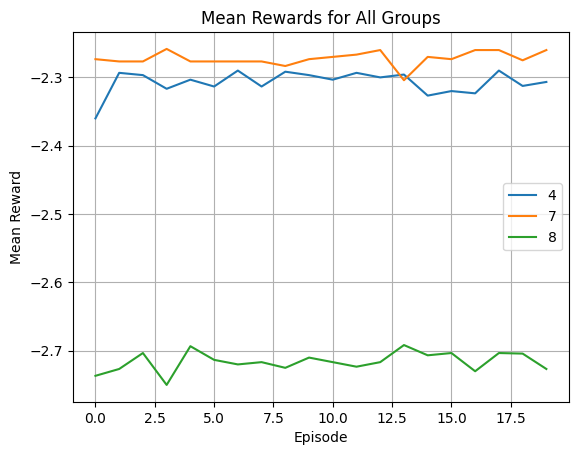

In [ ]:
plt.figure()
for group in env.group_map.keys():
    rewards = episode_reward_mean_map[group]
    plt.plot(rewards, label=group)

plt.title('Mean Rewards for All Groups')
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.legend()
plt.grid(True)
plt.show()

## Losses

### Total loss

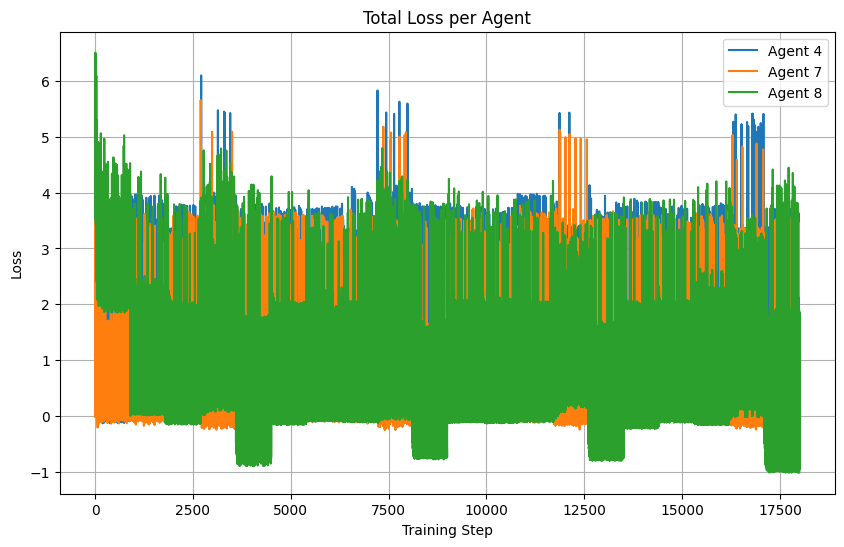

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

for agent_id, losses in loss.items():
    losses_np = [loss.detach().numpy() for loss in losses]
    plt.plot(losses_np, label=f'Agent {agent_id}')

plt.title('Total Loss per Agent')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Objective loss

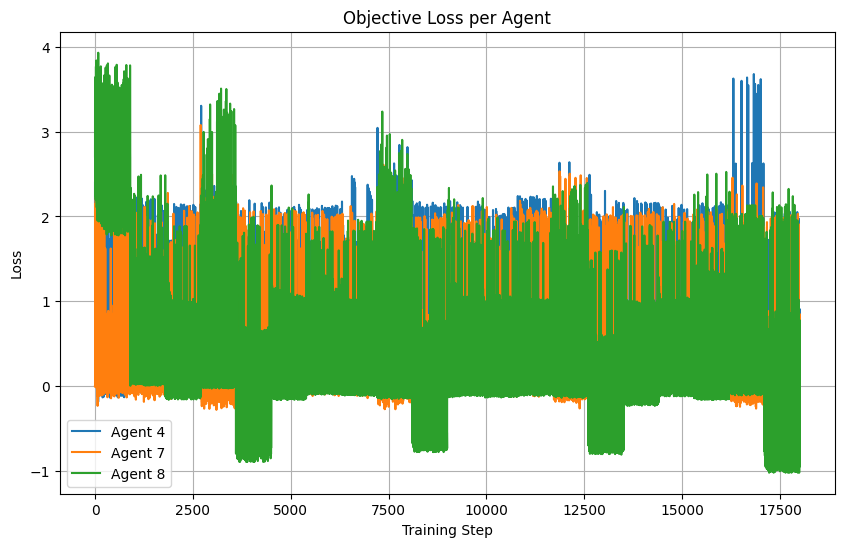

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

for agent_id, losses in loss_objective.items():
    losses_np = [loss.detach().numpy() for loss in losses]
    plt.plot(losses_np, label=f'Agent {agent_id}')

plt.title('Objective Loss per Agent')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Entropy loss

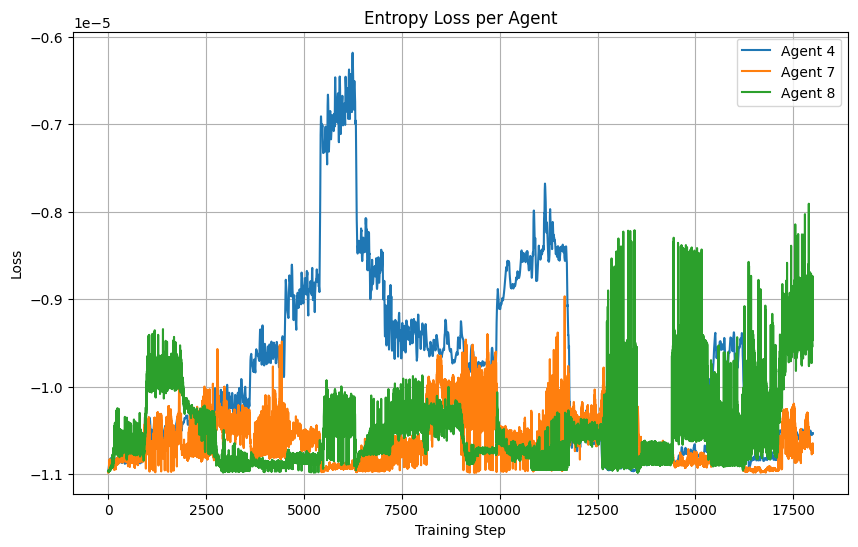

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

for agent_id, losses in loss_entropy.items():
    losses_np = [loss.detach().numpy() for loss in losses]
    plt.plot(losses_np, label=f'Agent {agent_id}')

plt.title('Entropy Loss per Agent')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Critic loss

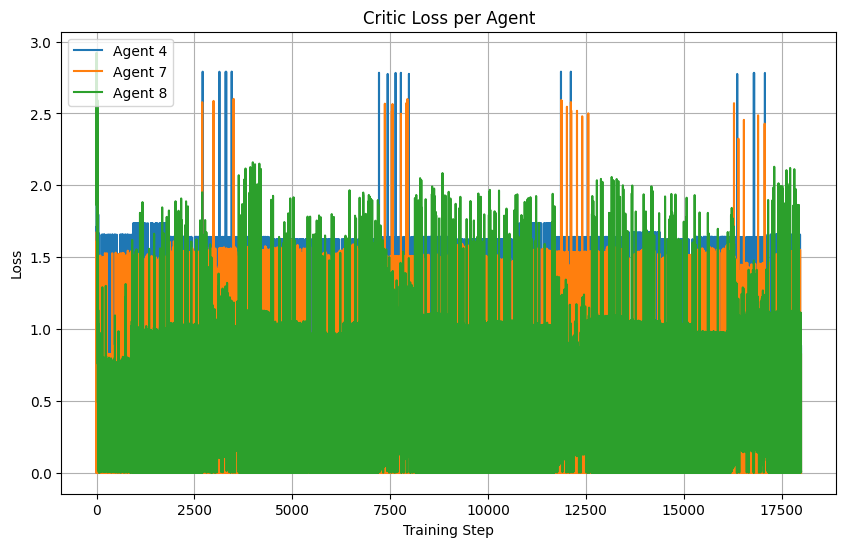

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

for agent_id, losses in loss_critic.items():
    losses_np = [loss.detach().numpy() for loss in losses]
    plt.plot(losses_np, label=f'Agent {agent_id}')

plt.title('Critic Loss per Agent')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from services import plotter

plotter(params[kc.PLOTTER])